In [1]:
# import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
path_all_tfrecord = "fp56.tfrecord"

In [3]:
dir_from = "/data/fp_img_processed/"

In [4]:
dir_model = "vgg_cam/"
path_best = dir_model + "model-17-1.17-53.3%.hdf5"
path_best

'vgg_cam/model-17-1.17-53.3%.hdf5'

# model

In [5]:
from fp_tensorflow import create_pair_56_dataset, create_single_dataset
from fp_tensorflow import create_vgg_5y_model

model = create_vgg_5y_model()
model.load_weights(path_best)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 56, 56, 6)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 56, 56, 64)        3520      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 56, 56, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0

# class activation map

In [6]:
# Get the 512 input weights to the softmax.
class_weights = model.layers[-1].get_weights()[0]

In [7]:
class_weights.shape

(512, 10)

In [8]:
class_weights.mean(), class_weights.std()

(0.00048049624, 0.10877906)

In [9]:
def get_fp_output(fp, model=model):
    final_conv_layer = model.get_layer("conv5_3")
    get_output = K.function(
        [model.layers[0].input], [final_conv_layer.output, model.layers[-1].output]
    )

    conv_output, prediction = get_output(np.expand_dims(fp, 0))
    return np.squeeze(conv_output, axis=0), np.argmax(prediction)

In [10]:
def get_fp_cam(fp, model=model):
    class_weights = model.layers[-1].get_weights()[0]

    conv_output, prediction = get_fp_output(fp, model)
    true_class_weights = class_weights[:, prediction]

    cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for i, w in enumerate(true_class_weights):
        cam += w * conv_output[:, :, i]
    return cam

# biclust CAM

In [11]:
biclusts = np.loadtxt("biclust_col.txt", int)
biclusts

array([ 0, 12, 13,  2,  3, 12,  9,  3,  8, 12,  9, 12, 13, 11, 15,  7, 12,
        6, 10,  4, 13, 12,  4, 14,  4,  0, 15, 11,  1,  1, 12, 12, 11, 15,
        6,  3,  8, 11, 11,  7,  8,  6, 13,  9,  7,  5, 12,  1, 13,  9,  0,
        3, 10,  8,  9, 15, 13, 11, 12, 10, 15,  8, 12,  8,  4, 14,  7,  4,
        6,  6,  5,  4,  7, 13, 13,  9, 15, 14, 15,  9,  3,  2, 15,  8,  1,
        7,  9,  2,  3,  1,  3, 11,  2, 12,  6,  9,  2,  0,  8, 13, 12, 15,
       13, 13,  1, 10,  0,  3, 10,  7,  4, 12,  2,  4, 10,  3,  6,  4,  9,
        0,  0,  7,  7, 12,  0,  4,  7,  1,  3, 13,  7, 14, 11,  6,  8, 14,
        4, 15,  2, 12,  7, 15,  5, 12,  4,  7, 13,  9,  3, 15,  7, 11, 13,
       10,  4, 11,  3, 13,  8,  8,  2,  1,  9,  1,  1,  1, 15,  2,  5, 14,
        5,  3,  6, 12, 10,  0,  7,  3,  2,  3, 12,  5,  0, 12,  3, 12, 15,
        1, 12,  8,  4, 12,  3,  4,  9,  6,  2,  4,  6, 14, 13, 13,  1,  0,
       13, 12,  9,  8, 15, 10,  4,  3,  2, 12,  6,  2,  0, 12, 15,  3,  2,
       11, 12,  2, 10,  8

In [12]:
def get_biclust_cam(fp, biclust, model=model, labels=biclusts):
    conv_output, _ = get_fp_output(fp, model)

    return conv_output[..., biclusts == biclust].sum(axis=2)

# plot

In [13]:
def plot_bgr(img):
    fig = plt.figure(figsize=(2, 2), dpi=300)
    plt.axes().axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()

In [14]:
def plot_rgb(img):
    fig = plt.figure(figsize=(2, 2), dpi=300)
    plt.axes().axis("off")
    plt.imshow(img)
    plt.tight_layout()

In [15]:
def plot_gray(img, cmap=plt.cm.gray):
    fig = plt.figure(figsize=(2, 2), dpi=300)
    plt.axes().axis("off")
    plt.imshow(img, cmap=cmap)
    plt.tight_layout()

# run

In [16]:
from floorplan_analysis import read_mono_from_image_unicode
from floorplan_analysis import fp_float_from_mono
from floorplan_analysis import pad_fp

In [17]:
mono = read_mono_from_image_unicode(dir_from + "2888_118A" + ".png")
fp_full = fp_float_from_mono(mono)
fp = pad_fp(fp_full, 56, 56)

conv_output, prediction = get_fp_output(fp)

In [18]:
fp_full.shape

(62, 60, 6)

In [19]:
conv_output.shape, prediction.shape

((14, 14, 512), ())

In [20]:
prediction

5

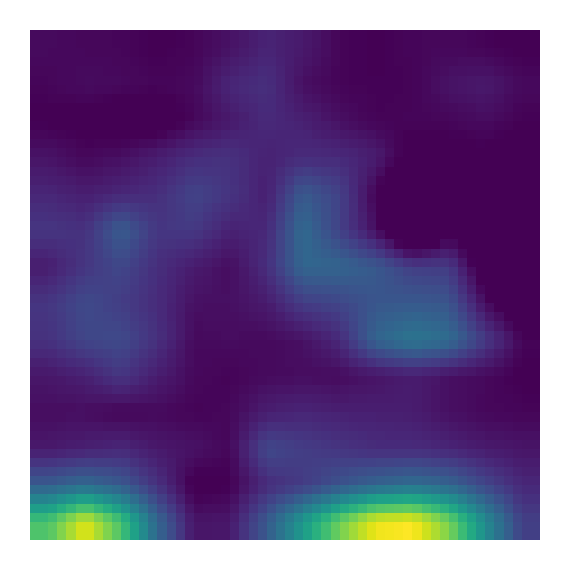

In [21]:
cam = get_fp_cam(fp)
cam = cv2.resize(cam, (56, 56))
cam /= cam.max()
cam[cam <= 0] = 0

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS,)
# heatmap[cam < 0.2] = 0
plot_bgr(heatmap)

77.86572


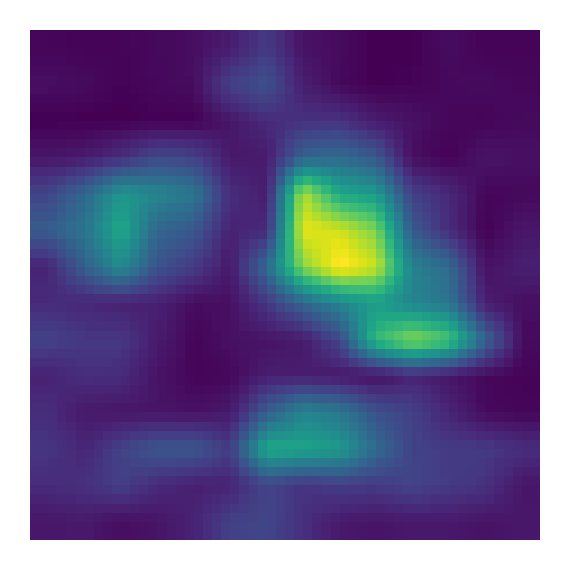

In [22]:
cam = get_biclust_cam(fp, 3)

cam = cv2.resize(cam, (56, 56))
print(cam.max())
cam /= cam.max()
cam[cam <= 0] = 0

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS,)
# heatmap[cam < 0.4] = 0
plot_bgr(heatmap)

In [23]:
def visualize_fp(fps):
    # adjusted for different luminance
    channel_to_rgba = np.array(
        [
            [0.0, 0.0, 0.0, 0.0],  # wall to black L0
            [0.0, 0.33, 0.0, 0.0],  # entrance to green L30
            [1.0, 0.25, 0.0, 0.0],  # LDK to red L57
            [0.83, 0.87, 0.0, 0.0],  # bedroom to yellow L85
            [0.0, 0.26, 1.0, 0.0],  # balcony to blue L40
            [0.0, 0.81, 0.76, 0.0],  # bathroom to cyan L75
        ]
    )

    # make colors subtractive
    channel_to_rgba[:, 0:3] -= 1

    # put it on white
    fps_rgba = np.clip(
        np.array([1.0, 1.0, 1.0, 1.0]) + (np.array(fps) @ channel_to_rgba), 0, 1
    )
    return fps_rgba.astype(np.float32)

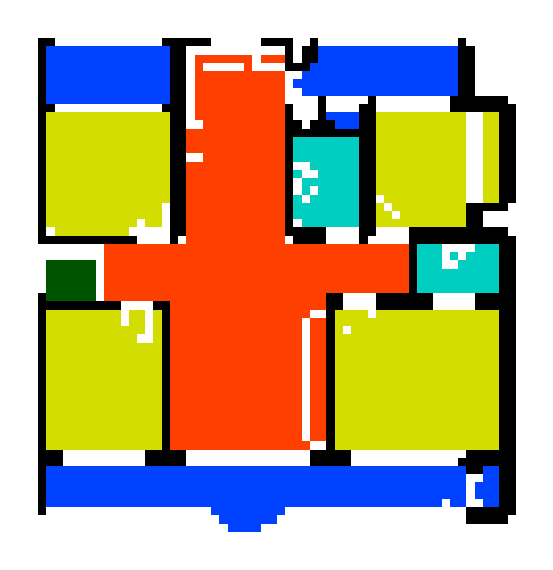

In [24]:
rgba = visualize_fp(fp_full)
plot_rgb(rgba)

In [25]:
def visualize_fp_cam(fp):
    fp_rgba = visualize_fp(fp)
    fp_light = cv2.cvtColor(fp_rgba, cv2.COLOR_RGB2Lab)[:, :, 0] / 100

    fp_pad = pad_fp(fp, 56, 56)

    cam = get_fp_cam(fp_pad)
    cam = cv2.resize(cam, (56, 56))
    cam /= cam.max()
    cam[cam <= 0] = 0

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS)
    heatmap = pad_fp(heatmap, fp_light.shape[1], fp_light.shape[0])
    heatmap[fp_light == 0] = 0
    heatmap = heatmap.astype(np.float32) / 255

    return 0.7 * heatmap + 0.3 * np.expand_dims(fp_light, 2)

In [26]:
def visualize_biclust_cam(fp, biclust):
    fp_rgba = visualize_fp(pad_fp(fp, max(56, fp.shape[1]), max(56, fp.shape[0])))
    fp_light = cv2.cvtColor(fp_rgba, cv2.COLOR_RGB2Lab)[:, :, 0] / 100

    fp_pad = pad_fp(fp, 56, 56)

    cam = get_biclust_cam(fp_pad, biclust)
    cam = cv2.resize(cam, (56, 56))
    cam /= cam.max()
    cam[cam <= 0] = 0

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS)
    #     heatmap = pad_fp(heatmap, fp_light.shape[1], fp_light.shape[0])
    heatmap = pad_fp(heatmap, max(56, fp_light.shape[1]), max(56, fp_light.shape[0]))
    heatmap = heatmap.astype(np.float32) / 255

    return 0.7 * heatmap + 0.3 * np.expand_dims(fp_light, 2)

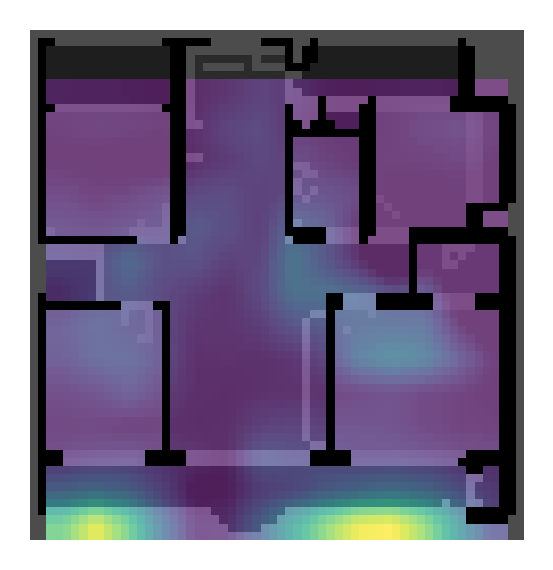

In [27]:
plot_bgr(visualize_fp_cam(fp_full))

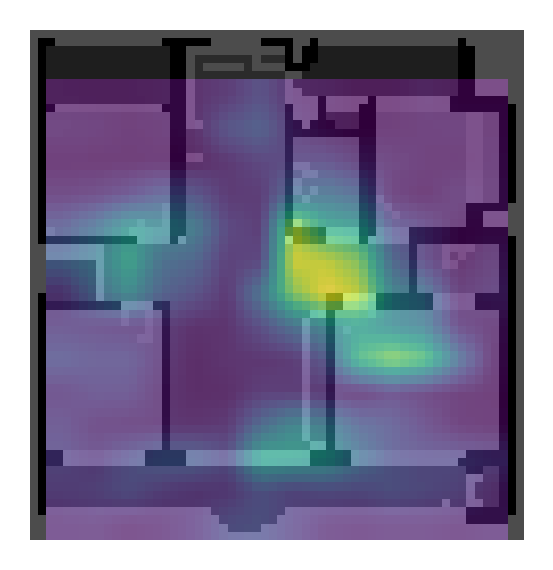

In [28]:
plot_bgr(visualize_biclust_cam(fp_full, 3))

# process representative floorplans

In [29]:
df = pd.read_csv("biclust.csv")
df["area_group"] = pd.cut(df.Area, [0, 50, 60, 85, np.inf], labels=False)
df

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
0,0,0,8928_160,6,6,2004,0,134.30,4,2,7,3
1,1,1,8928_183,6,6,2004,0,153.80,4,2,4,3
2,2,2,8928_201A,6,7,2004,0,170.32,4,2,10,3
3,3,3,8928_204B,6,6,2004,0,168.42,4,2,8,3
4,4,4,960_35,2,4,1982,0,35.64,2,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
50247,50247,50247,115454_21D,9,9,2017,8,14.50,2,1,14,0
50248,50248,50248,115454_34E,9,9,2017,8,21.57,2,1,14,0
50249,50249,50249,115454_36B,9,9,2017,8,24.86,3,2,14,0
50250,50250,50250,115454_37A,9,9,2017,8,25.67,3,2,14,0


In [30]:
df_sample = df.groupby(["cluster", "area_group"]).sample(frac=0.005, random_state=1106)
df_sample = df_sample.sort_values(["cluster", "area_group", "year"])
df_sample

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
13554,13554,13554,3824_61A,0,3,1972,0,55.41,2,1,0,1
22441,22441,22441,1750_74B,1,7,1979,1,64.89,2,1,0,2
7806,7806,7806,426_112,3,4,1987,0,84.33,3,1,0,2
8595,8595,8595,474_104C,3,3,1988,0,79.80,3,1,0,2
862,862,862,501_114A,2,4,1981,0,106.22,3,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
21701,21701,21701,26762_134A,8,9,2010,1,101.71,4,2,15,3
41233,41233,41233,105812_140,8,9,2014,5,110.82,3,2,15,3
4548,4548,4548,107066_133C-7,8,9,2014,0,101.97,4,2,15,3
21040,21040,21040,107017_144C,9,9,2015,1,110.97,4,2,15,3


In [31]:
pd.crosstab(df_sample.cluster, df_sample.area_group)

area_group,0,1,2,3
cluster,,,,
0,0,1,3,4
1,0,1,7,6
2,2,2,3,1
3,2,7,9,4
4,1,3,7,5
5,4,3,2,0
6,3,7,4,2
7,0,3,11,6
8,0,2,9,5


In [32]:
pd.crosstab(df_sample.cluster, df_sample.area_group).max(axis=0)

area_group
0     9
1     7
2    15
3    13
dtype: int64

In [33]:
widths = np.asarray([3, 4, 8, 7])

coords_col = np.insert(np.cumsum(widths), 0, 0)[:-1]
coords_col

array([ 0,  3,  7, 15])

In [34]:
heights = np.maximum(
    np.ceil(
        pd.crosstab(df_sample.cluster, df_sample.area_group).to_numpy() / widths
    ).astype(int),
    1,
).max(axis=1)
heights

array([1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 3, 2])

In [35]:
coords_row = np.insert(np.cumsum(heights), 0, 0,)[:-1]
coords_row

array([ 0,  1,  2,  3,  5,  6,  8, 10, 12, 14, 15, 17, 19, 20, 22, 25])

In [36]:
sum(heights)

27

In [37]:
sum(widths)

22

총 31줄, 19열

In [38]:
u = 84  # unit size
flip = False

In [39]:
if not flip:
    img_size = (sum(heights) * u, sum(widths) * u)
else:
    img_size = (sum(widths) * u, sum(heights) * u)

In [40]:
img_size

(2268, 1848)

In [41]:
img = np.ones(img_size + (3,), np.float32)
# img = np.zeros(img_size + (3,), np.float32)

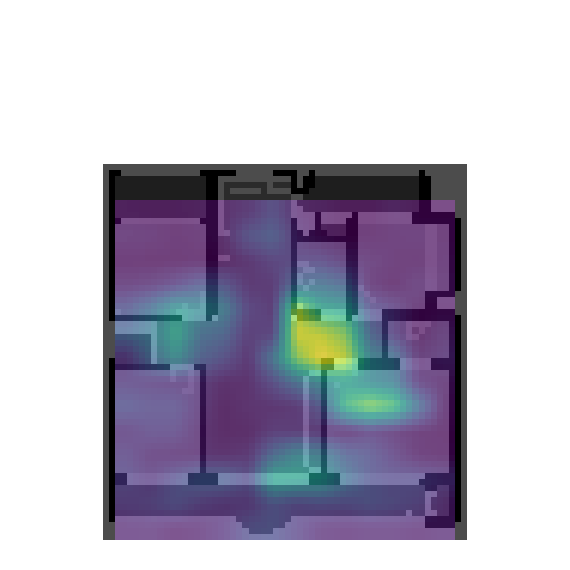

In [42]:
plot_bgr(pad_fp(visualize_biclust_cam(fp_full, 3), u, u, 1))

In [43]:
df_sample[(df_sample.cluster == 0) & (df_sample.area_group == 2)]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
22441,22441,22441,1750_74B,1,7,1979,1,64.89,2,1,0,2
7806,7806,7806,426_112,3,4,1987,0,84.33,3,1,0,2
8595,8595,8595,474_104C,3,3,1988,0,79.80,3,1,0,2


In [44]:
df_sample[(df_sample.cluster == 0) & (df_sample.area_group == 2)].ID.iloc[1]

'426_112'

In [45]:
for ir, rr in enumerate(coords_row):
    for ic, cc in enumerate(coords_col):
        df_clust = df_sample[(df_sample.cluster == ir) & (df_sample.area_group == ic)]
        for i in range(len(df_clust)):
            r = i // widths[ic]
            c = i - r * widths[ic]
            id_ = df_clust.iloc[i].ID
            clust = df_clust.iloc[i].cluster

            img[
                (rr + r) * u : (rr + r + 1) * u, (cc + c) * u : (cc + c + 1) * u
            ] = pad_fp(
                visualize_biclust_cam(
                    fp_float_from_mono(
                        read_mono_from_image_unicode(dir_from + id_ + ".png")
                    ),
                    clust,
                ),
                u,
                u,
                1,
            )

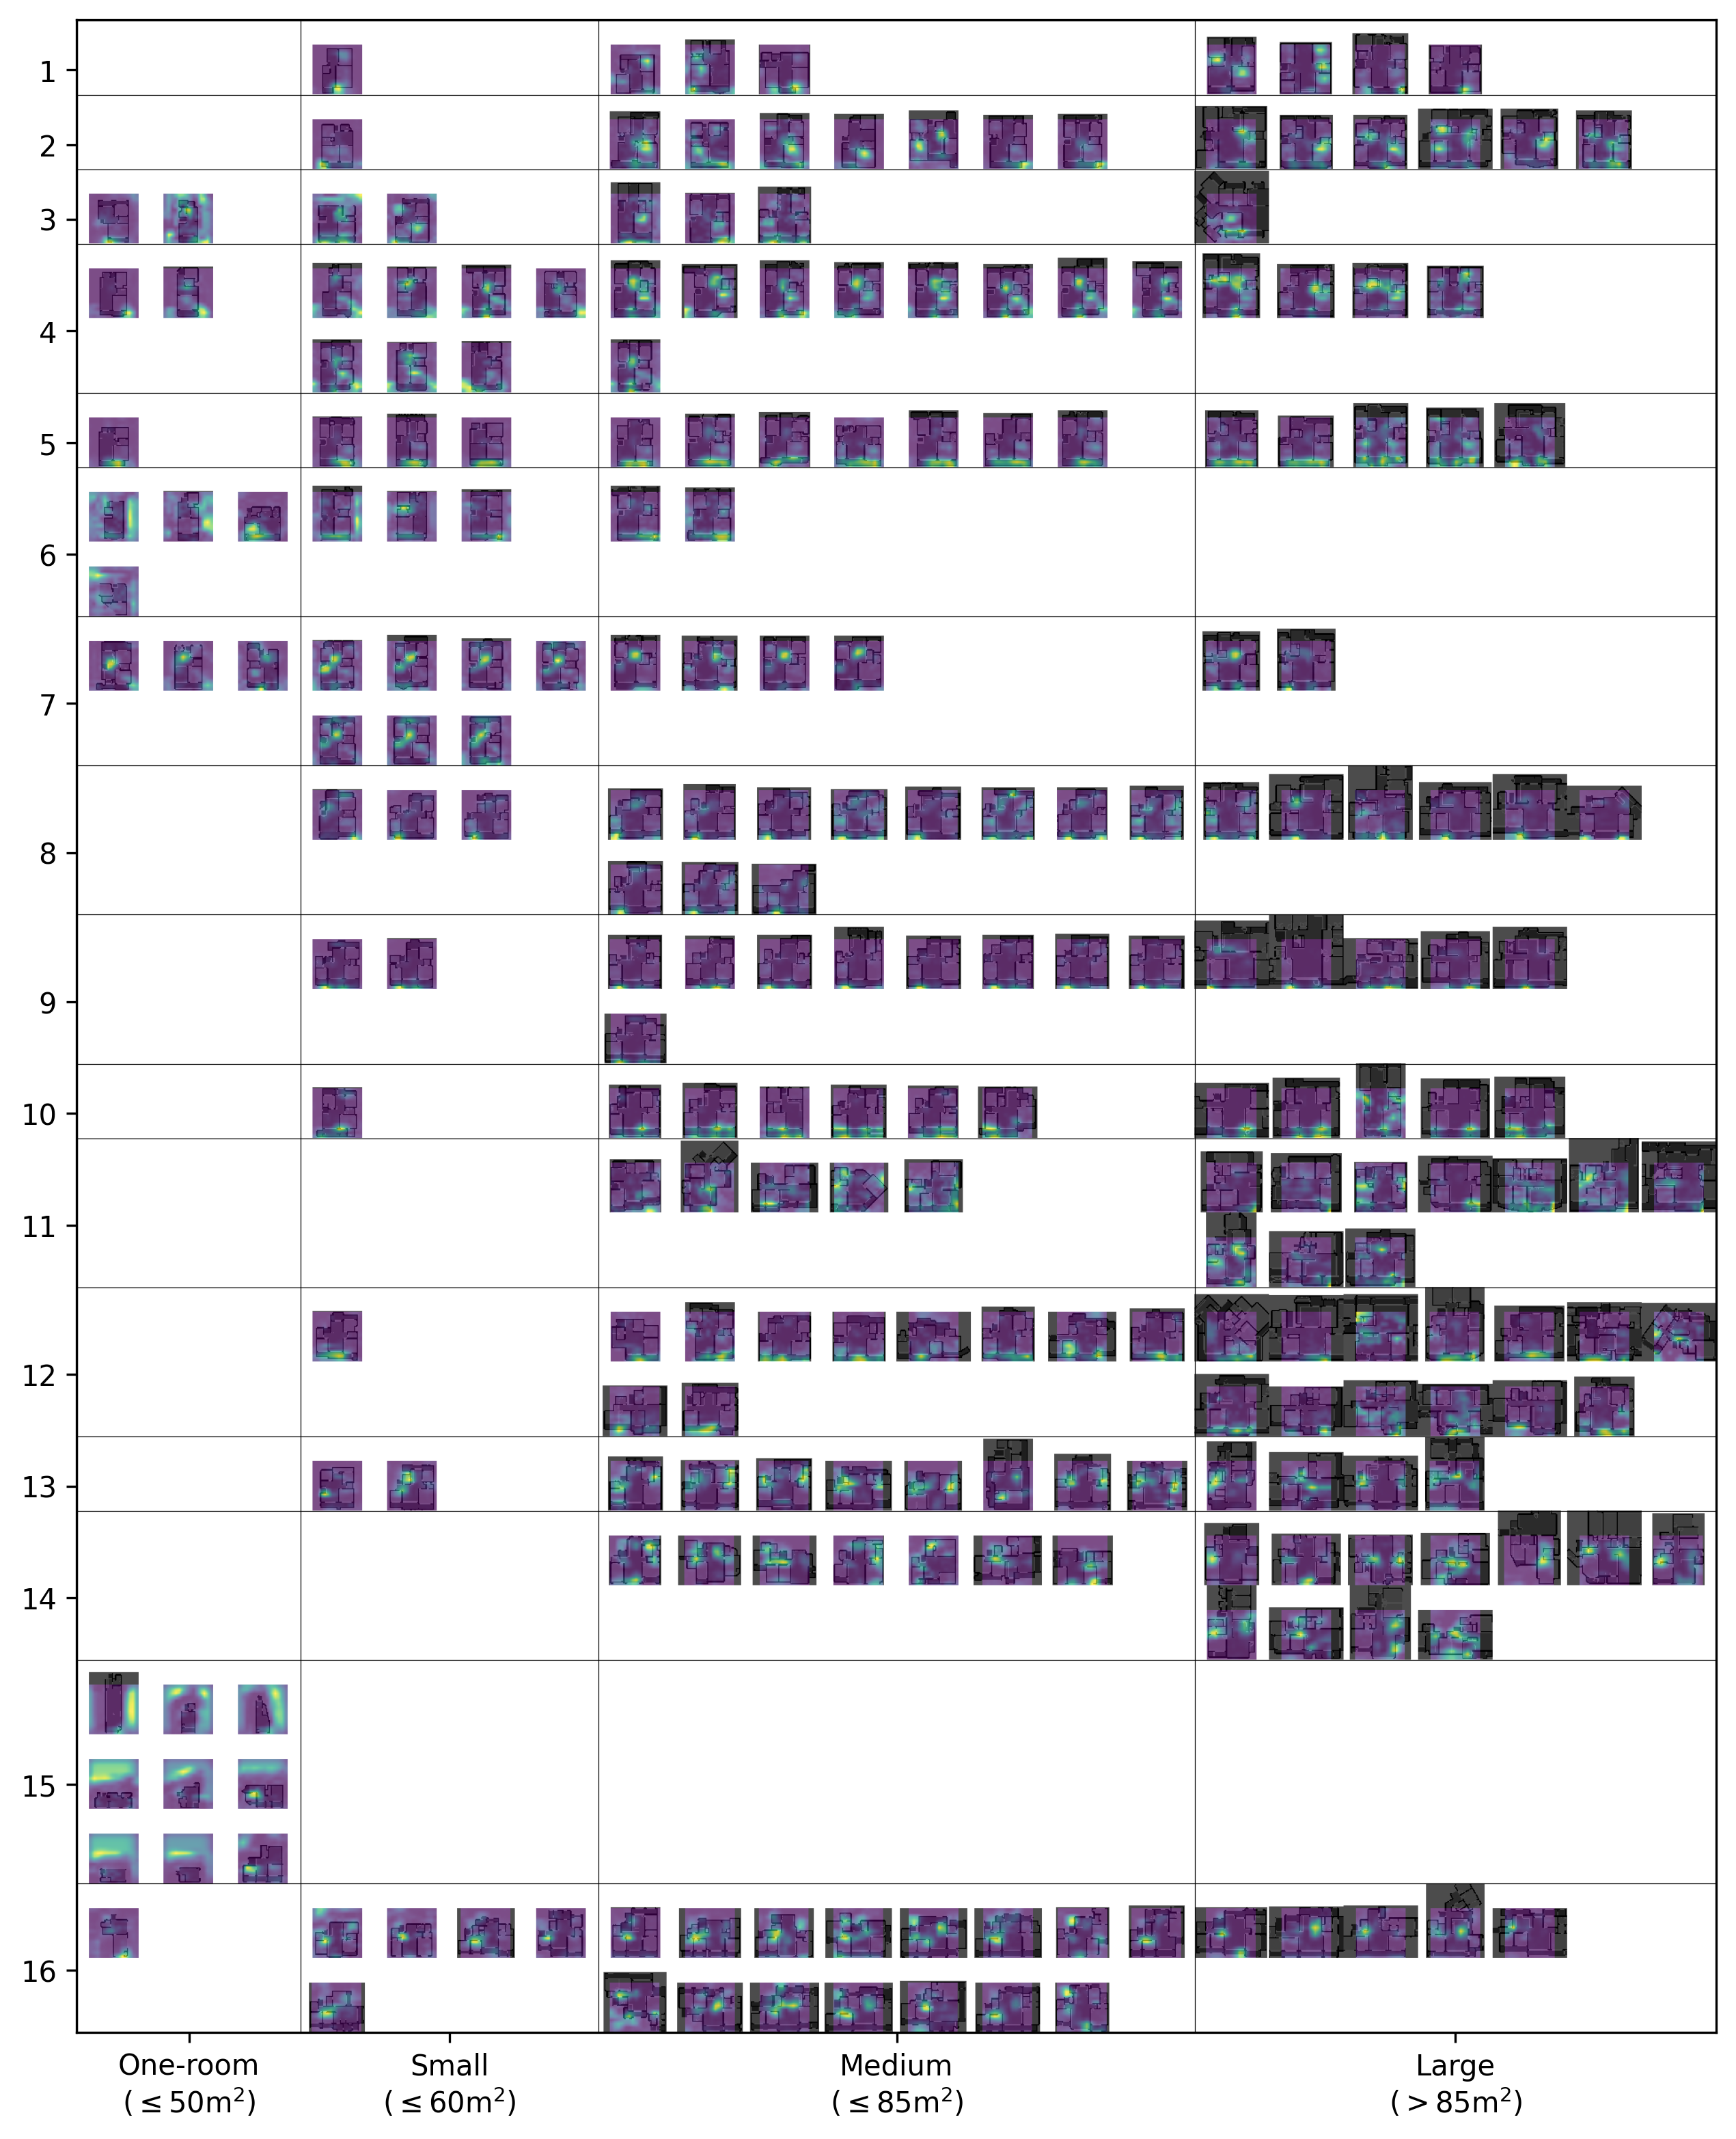

In [46]:
fig = plt.figure(figsize=(11, 13), dpi=300)
ax = fig.gca()
im = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_xticks((coords_col + widths / 2) * u)
ax.set_xticklabels(
    [
        "One-room\n($\leq50\mathrm{m^2}$)",
        "Small\n($\leq60\mathrm{m^2}$)",
        "Medium\n($\leq85\mathrm{m^2}$)",
        "Large\n($>85\mathrm{m^2}$)",
    ]
)
ax.set_yticks((coords_row + heights / 2 + 1 / 6) * u)
ax.set_yticklabels(range(1, biclusts.max() + 2))

ax.vlines(coords_col * u, 0, heights.sum() * u - 1, colors="k", lw=0.3)
ax.hlines(coords_row * u, 0, widths.sum() * u - 1, colors="k", lw=0.3)

fig.savefig("bam.png", bbox_inches="tight", pad_inches=0)
fig.savefig("bam.pdf", bbox_inches="tight", pad_inches=0)

In [47]:
df_sample[(df_sample.cluster == 0)]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
13554,13554,13554,3824_61A,0,3,1972,0,55.41,2,1,0,1
22441,22441,22441,1750_74B,1,7,1979,1,64.89,2,1,0,2
7806,7806,7806,426_112,3,4,1987,0,84.33,3,1,0,2
8595,8595,8595,474_104C,3,3,1988,0,79.80,3,1,0,2
862,862,862,501_114A,2,4,1981,0,106.22,3,1,0,3
42640,42640,42640,5520_150,2,4,1983,7,122.08,4,2,0,3
14849,14849,14849,1248_146,4,4,1993,0,125.48,4,2,0,3
42826,42826,42826,14414_121A,5,4,1999,3,99.88,4,2,0,3


101160_113E
103915_112C
104127_107B
107903_113G
108838_117B

In [48]:
def plot_bgr_scale(img):
    size_x, size_y = img.shape[:2]
    fig = plt.figure(figsize=(2 * size_x / 112, 2 * size_y / 112), dpi=300)
    plt.axes().axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()

109582_52C


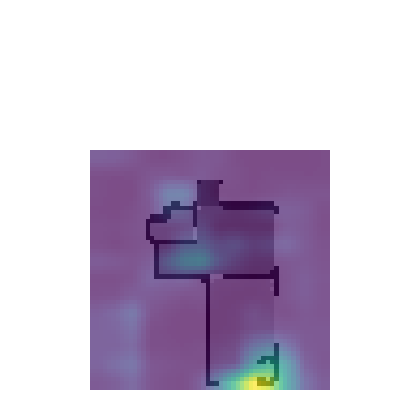

In [49]:
ir, ic, i = 15, 0, 0
u_single = 84  # 56 84 112
df_clust = df_sample[(df_sample.cluster == ir) & (df_sample.area_group == ic)]
id_ = df_clust.iloc[i].ID
print(id_)
clust = df_clust.iloc[i].cluster
plot_bgr_scale(
    pad_fp(
        visualize_biclust_cam(
            fp_float_from_mono(read_mono_from_image_unicode(dir_from + id_ + ".png")),
            clust,
        ),
        u_single,
        u_single,
        1,
    )
)

In [53]:
def plot_bams(
    id_, types,
):
    print(id_)
    fp = fp_float_from_mono(read_mono_from_image_unicode(dir_from + id_ + ".png"))
    size_y, size_x = np.fmax(fp.shape[:2], 56)

    clust_name = [
        "8090-1",
        "8090-2",
        "8090-3",
        "9000-1",
        "9000-2",
        "9000-3",
        "9000-4",
        "00-1",
        "00-2",
        "00-3",
        "00-4",
        "0010-1",
        "0010-2",
        "0010-3",
        "10-1",
        "10-2",
    ]
    clusts = [type - 1 for type in types]

    fig, axs = plt.subplots(1, len(clusts), figsize=(11 / 4 * len(clusts), 5), dpi=300)

    for i, clust in enumerate(clusts):
        ax = axs[i]
        img = pad_fp(visualize_biclust_cam(fp, clust,), size_x, size_y, 1,)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis("off")
        
        # title on bottom 
        # ax.set_title(clust_name[clust], y=-size_x / 56 / 10)
        
        # title on top
        ax.set_title(clust_name[clust], y=1)


    plt.tight_layout()
    return fig

# 1980년대: 판상형, 복도형

In [54]:
df_sample[
    (df_sample.year >= 1980)
    & (df_sample.year < 1990)
    & (df_sample.cluster.isin([0, 1, 2]))
    & (df_sample.area_group == 2)
]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
7806,7806,7806,426_112,3,4,1987,0,84.33,3,1,0,2
8595,8595,8595,474_104C,3,3,1988,0,79.80,3,1,0,2
23957,23957,23957,1995_103S,3,4,1985,1,84.85,3,1,1,2
4159,4159,4159,137_96,3,4,1986,0,73.08,3,1,1,2
9145,9145,9145,840_103,3,4,1989,0,84.33,3,1,1,2


복도형 중형

서울 구로 주공1차, 73.08㎡, 1986년

137_96


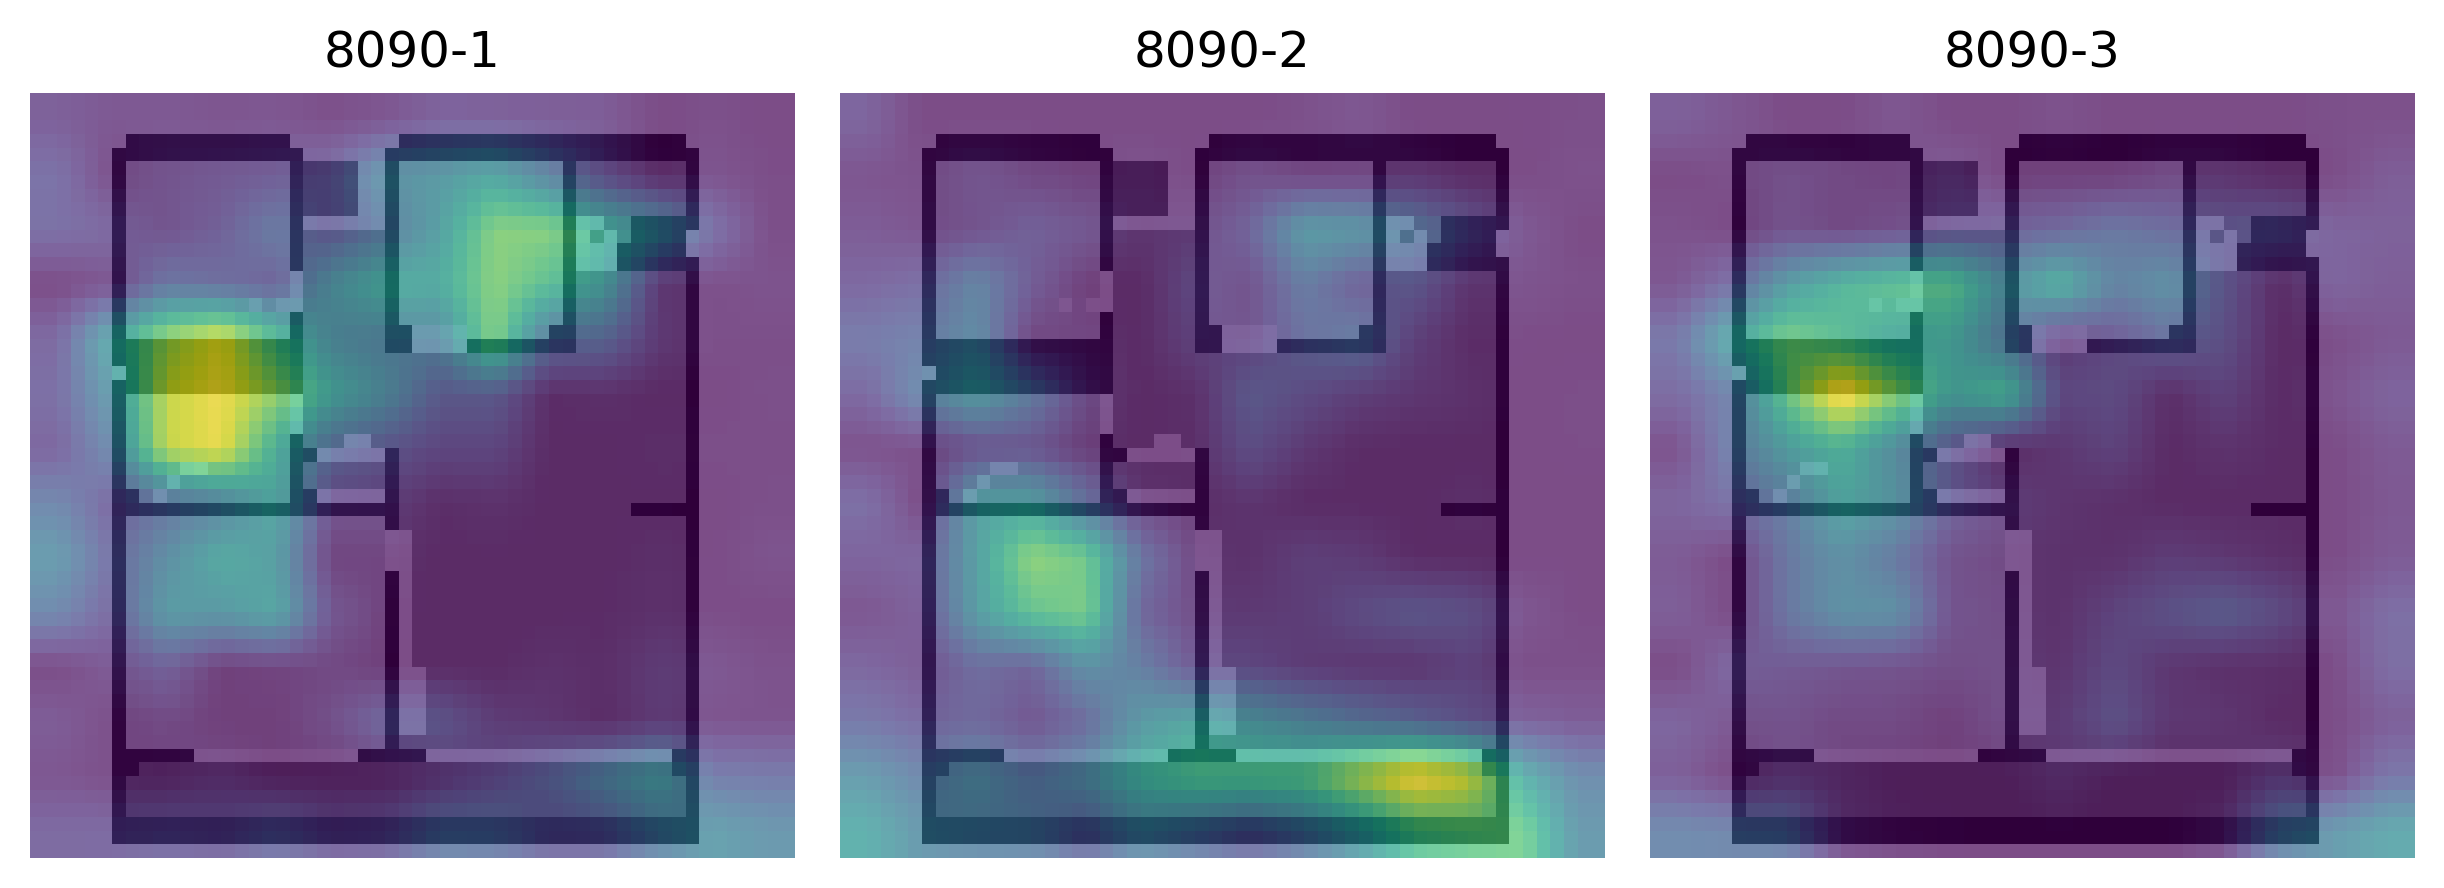

In [55]:
fig = plot_bams("137_96", [1, 2, 3])
# fig.savefig("bam.png", bbox_inches="tight", pad_inches=0)
# fig.savefig("bam.pdf", bbox_inches="tight", pad_inches=0)

In [56]:
df_sample[
    (df_sample.year >= 1980)
    & (df_sample.year < 1990)
    & (df_sample.cluster.isin([0, 1, 2]))
    & (df_sample.area_group == 3)
]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
862,862,862,501_114A,2,4,1981,0,106.22,3,1,0,3
42640,42640,42640,5520_150,2,4,1983,7,122.08,4,2,0,3
3881,3881,3881,100_174B,2,4,1983,0,166.93,5,2,1,3


복도형 대형

서울 압구정 한양7차, 106.22㎡, 1981년

501_114A


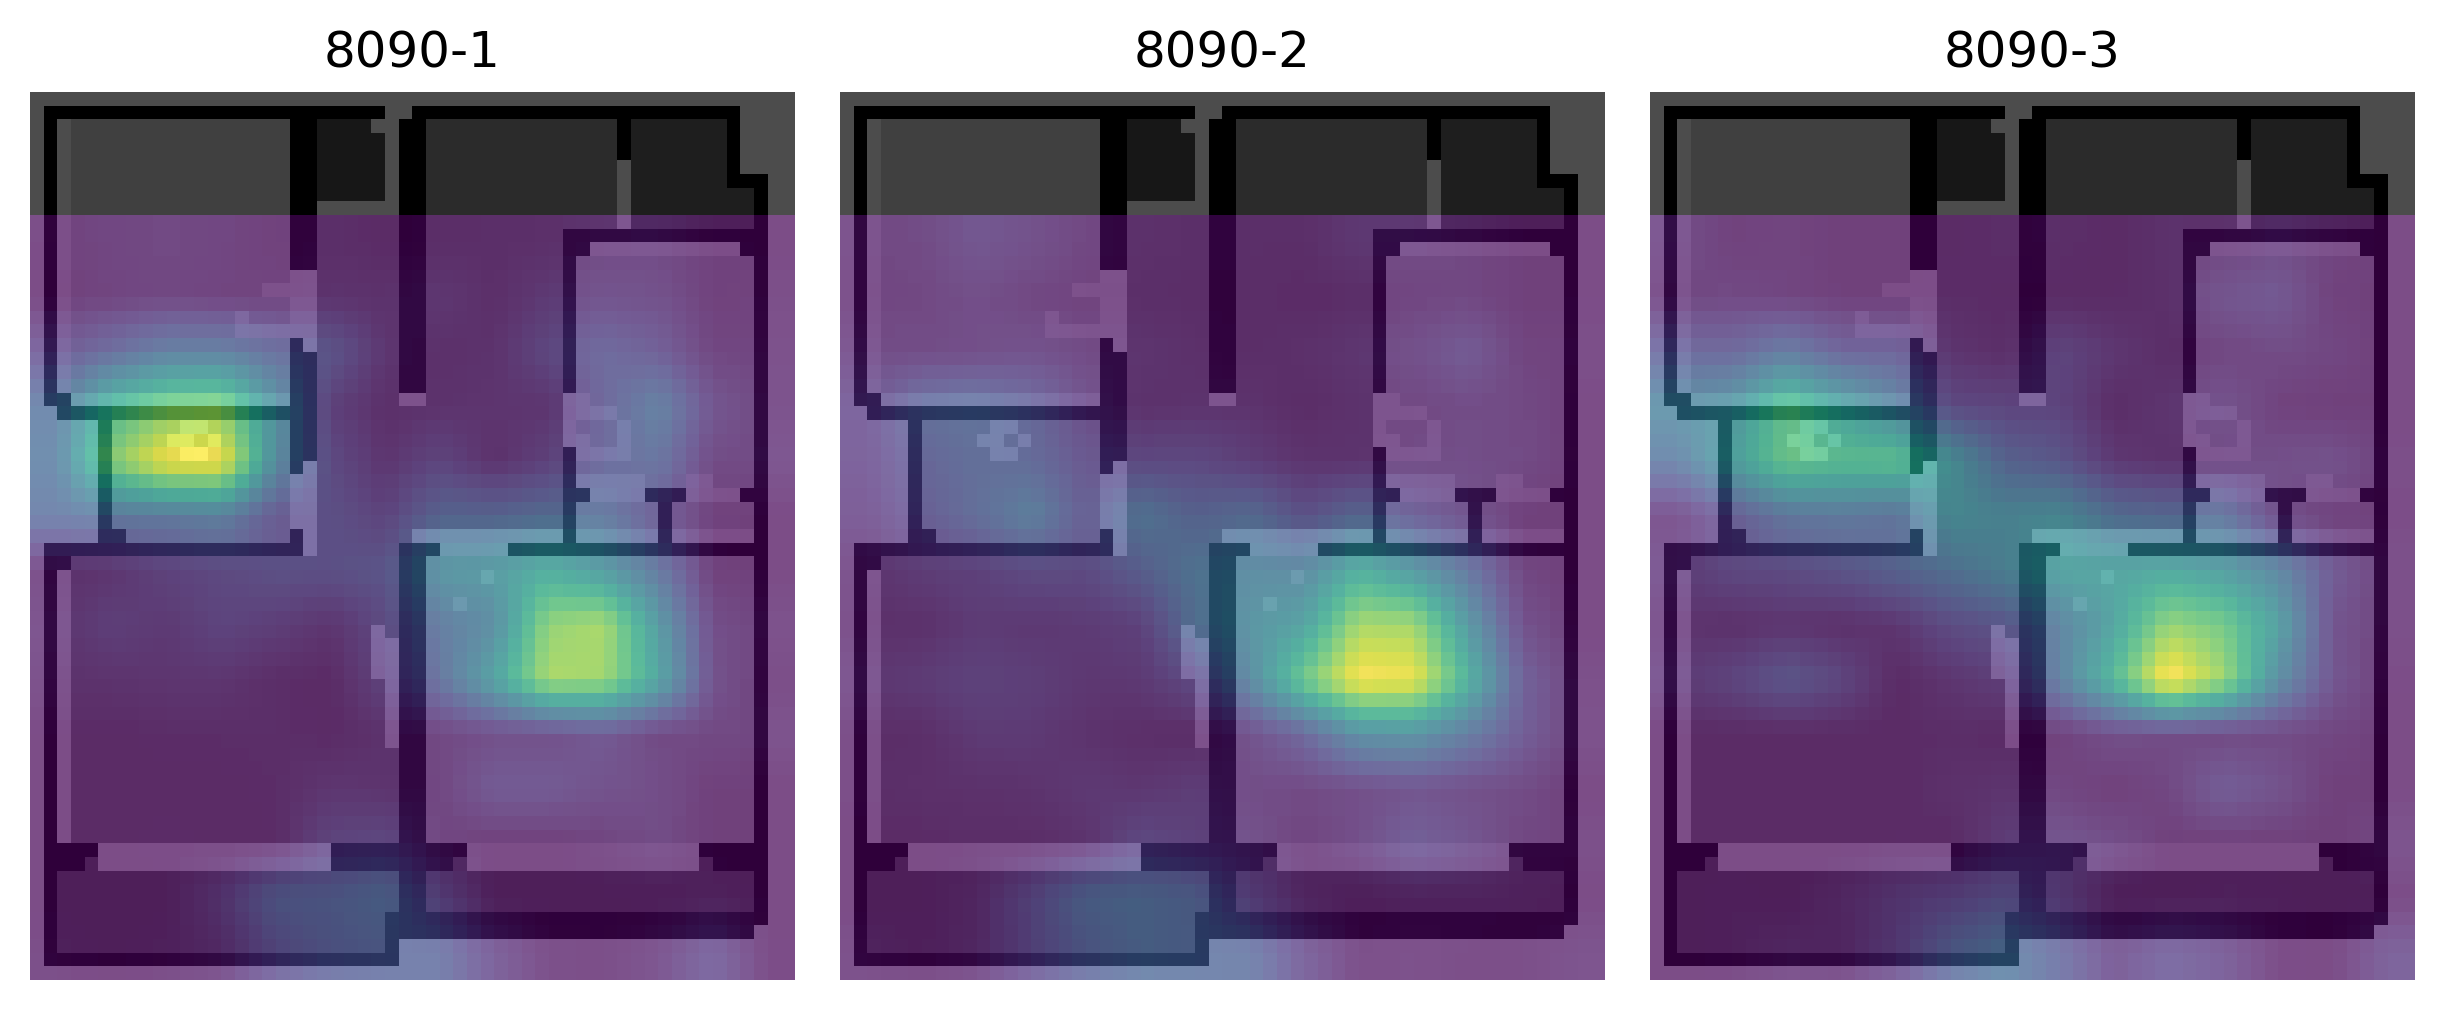

In [57]:
fig = plot_bams("501_114A", [1, 2, 3])
# fig.savefig("bam.png", bbox_inches="tight", pad_inches=0)
# fig.savefig("bam.pdf", bbox_inches="tight", pad_inches=0)

# 1990년대: 판상형, 계단실형

In [58]:
df_sample[(df_sample.cluster.isin([3])) & (df_sample.area_group == 2)]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
45882,45882,45882,7479_106,4,5,1994,4,84.82,3,2,3,2
11263,11263,11263,643_105B,5,5,1995,0,84.98,3,2,3,2
18438,18438,18438,8735_112,5,5,1996,1,84.98,3,2,3,2
782,782,782,8203_104,5,5,1997,0,84.97,3,2,3,2
40634,40634,40634,12082_107,5,5,1999,5,84.96,3,2,3,2
34918,34918,34918,6065_97,6,5,2000,5,75.65,3,2,3,2
9766,9766,9766,2976_107,6,5,2001,0,84.42,3,2,3,2
12092,12092,12092,11025_98,6,6,2003,0,76.68,3,2,3,2
11804,11804,11804,10343_81,6,5,2004,0,65.20,3,2,3,2


3LDK 중형

천안 일성3차, 84.82㎡, 1994년

7479_106
7479_106


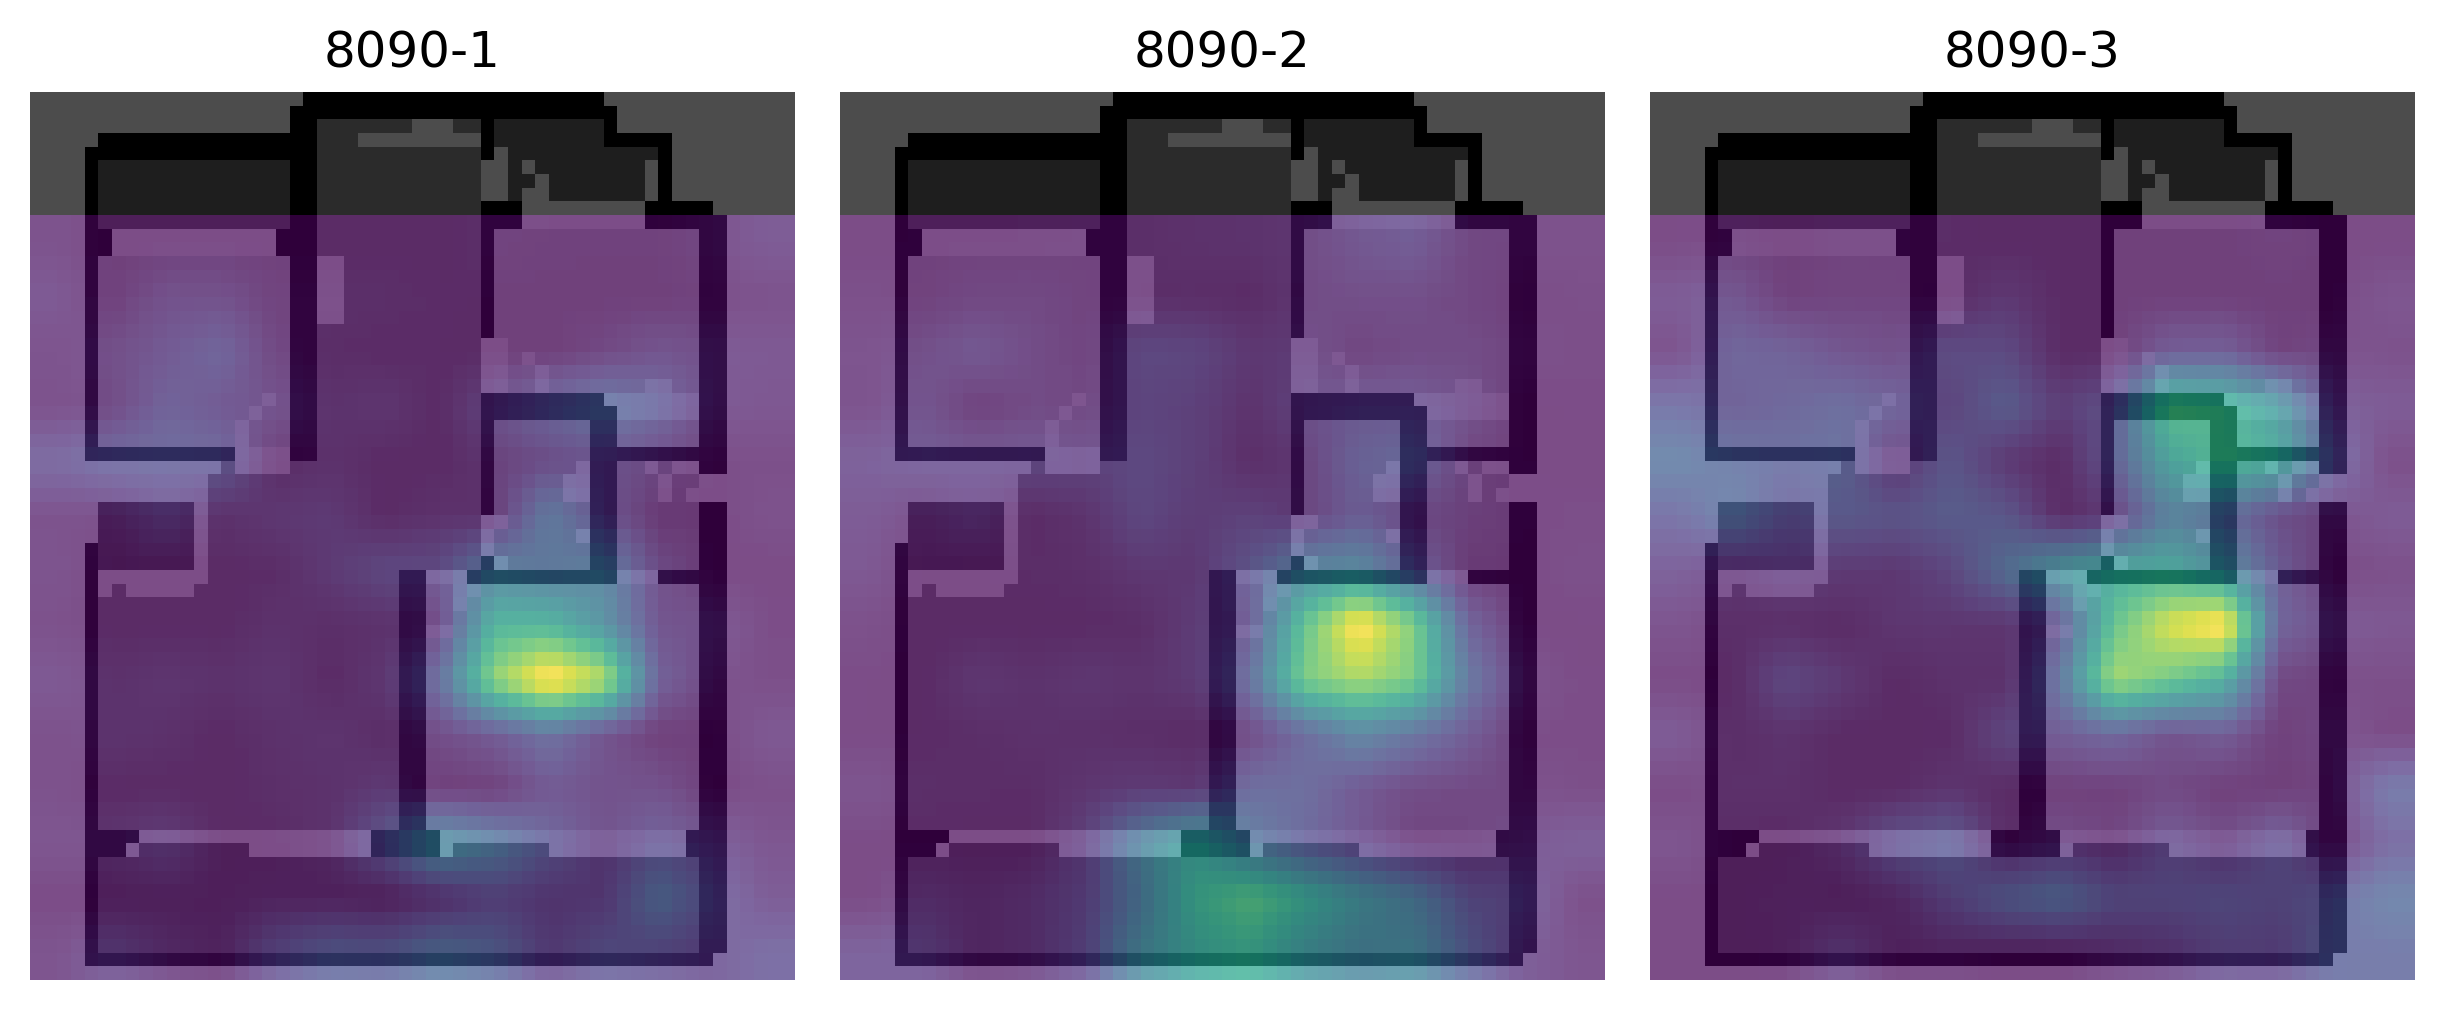

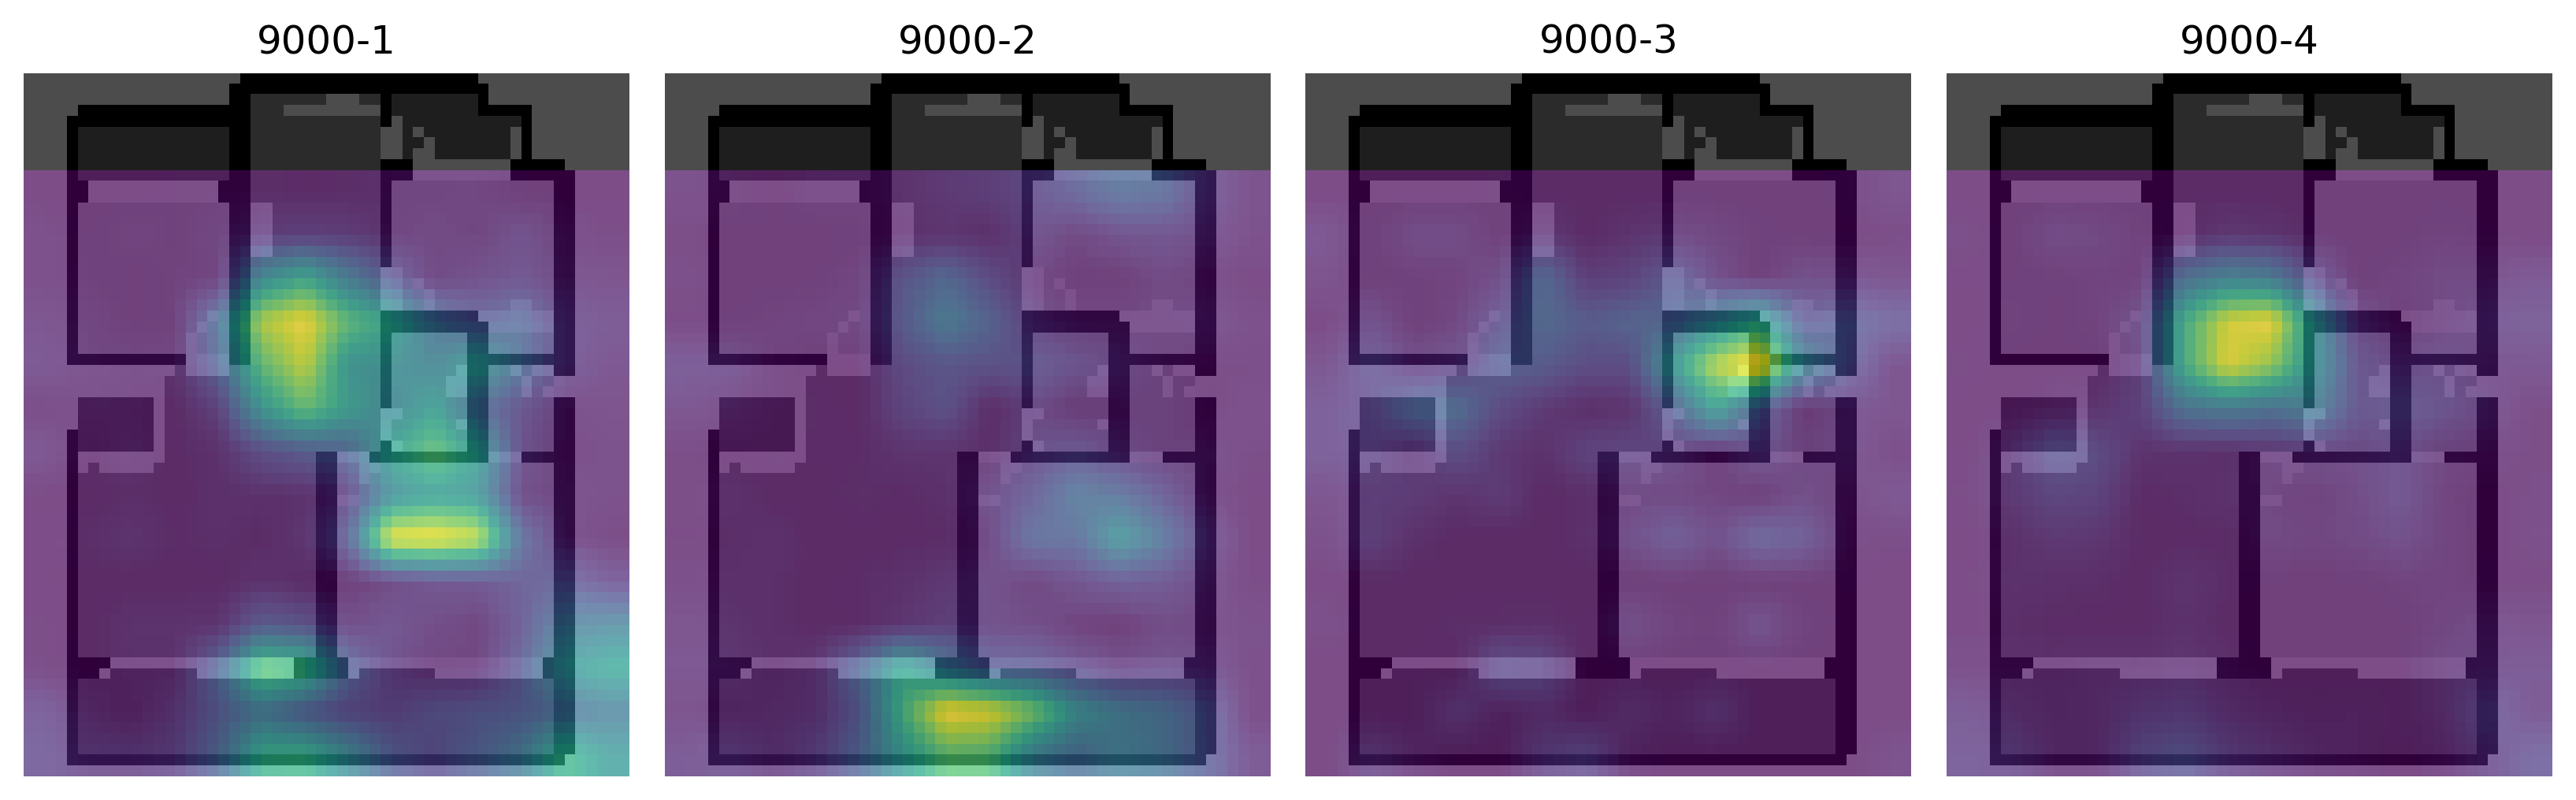

In [59]:
id_ = "7479_106"

fig1 = plot_bams(id_, [1, 2, 3])
fig2 = plot_bams(id_, range(4, 7 + 1))

# fig.savefig("bam.png", bbox_inches="tight", pad_inches=0)
# fig.savefig("bam.pdf", bbox_inches="tight", pad_inches=0)

In [60]:
df_sample[
    (df_sample.year >= 1990)
    & (df_sample.year < 2000)
    & (df_sample.cluster.isin(range(7 + 1)))
    & (df_sample.Rooms == 4)
]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
14849,14849,14849,1248_146,4,4,1993,0,125.48,4,2,0,3
42826,42826,42826,14414_121A,5,4,1999,3,99.88,4,2,0,3
17620,17620,17620,2895_125,4,4,1993,1,101.91,4,2,1,3
31895,31895,31895,2292_116,4,4,1994,2,99.42,4,2,1,3
3422,3422,3422,3170_150,5,4,1996,0,114.90,4,2,1,3
4858,4858,4858,8664_127,5,4,1997,0,100.82,4,2,1,3
24063,24063,24063,1449_157,4,5,1994,1,130.08,4,2,3,3
42421,42421,42421,5311_120,5,5,1995,7,95.65,4,2,3,3
15337,15337,15337,1534_122(한진),5,5,1995,1,101.88,4,2,3,3
11870,11870,11870,3781_153,5,6,1998,0,111.93,4,2,3,3


4LDK 대형

인천 연수 하나2차, 99.42㎡, 1994년

2292_116
2292_116


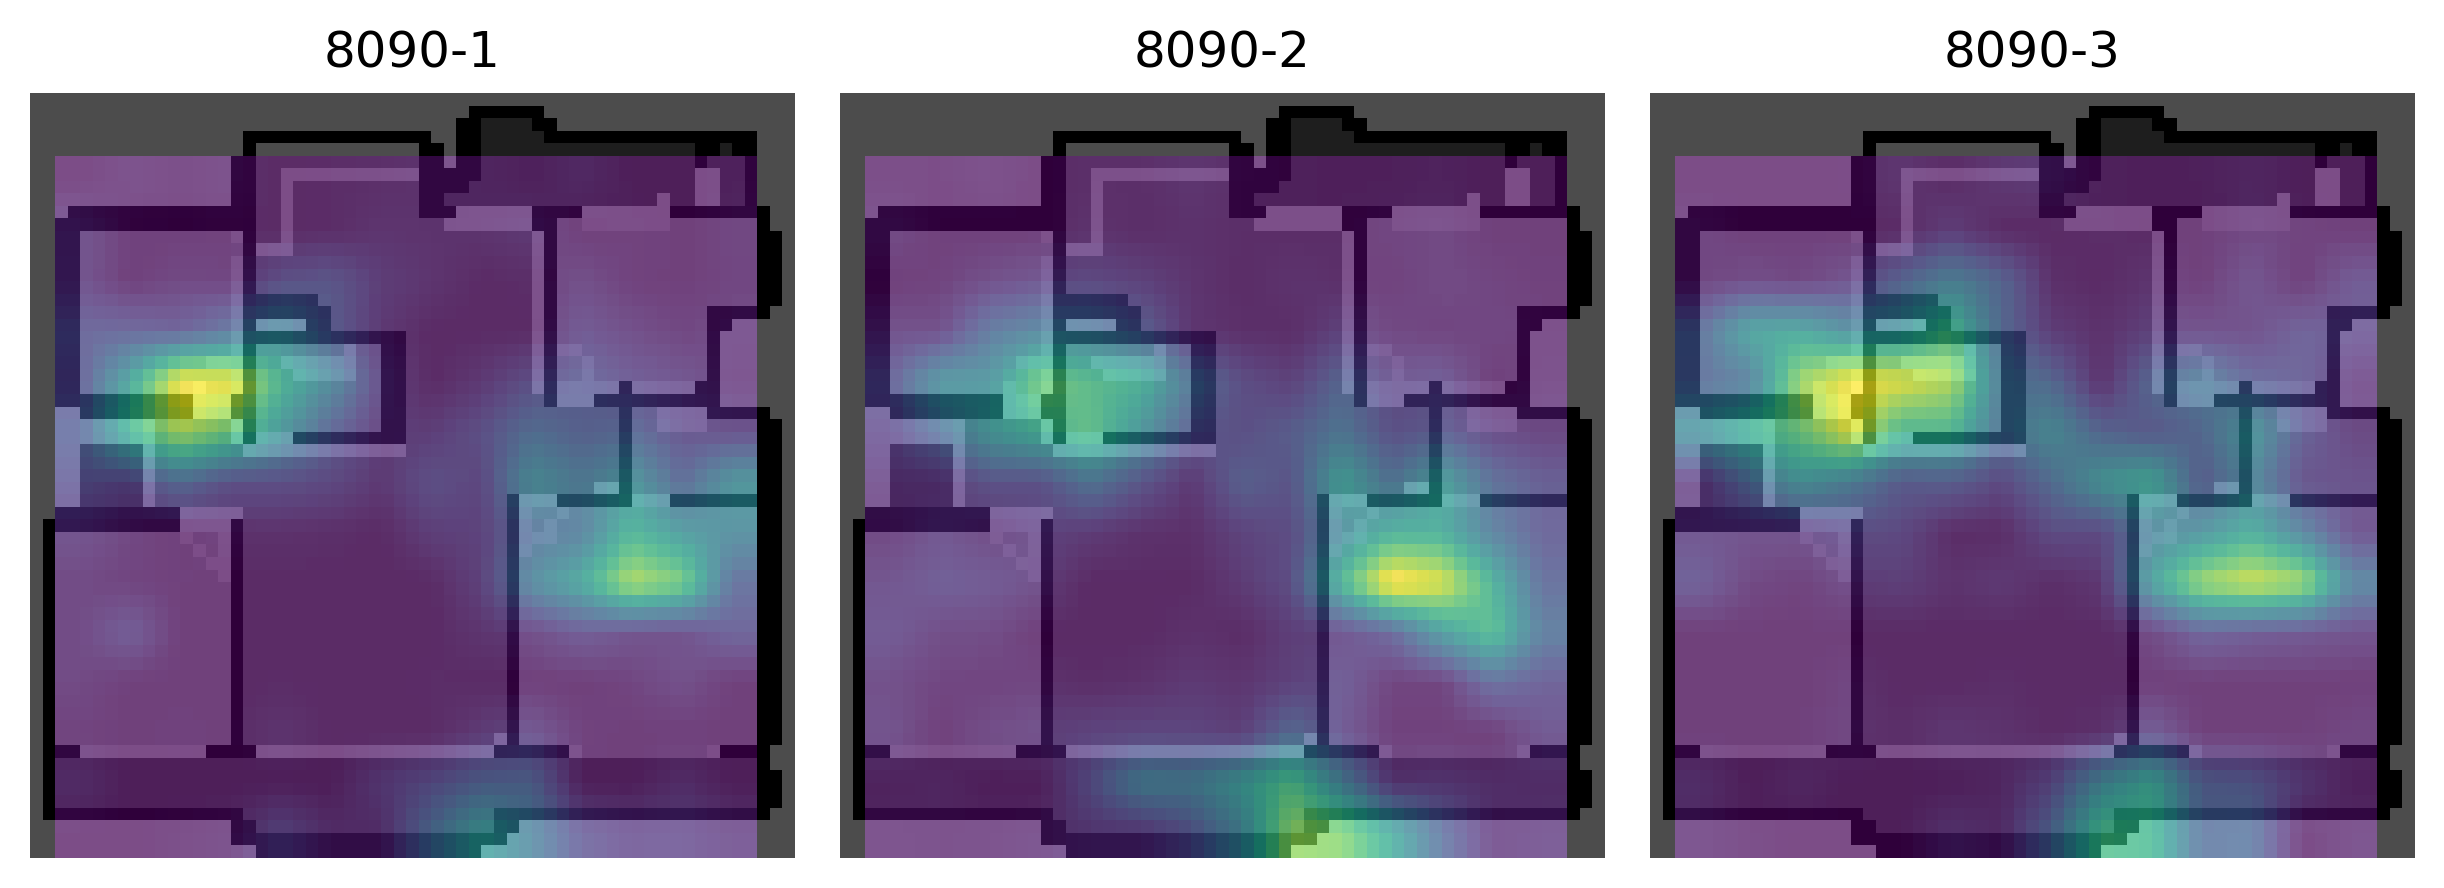

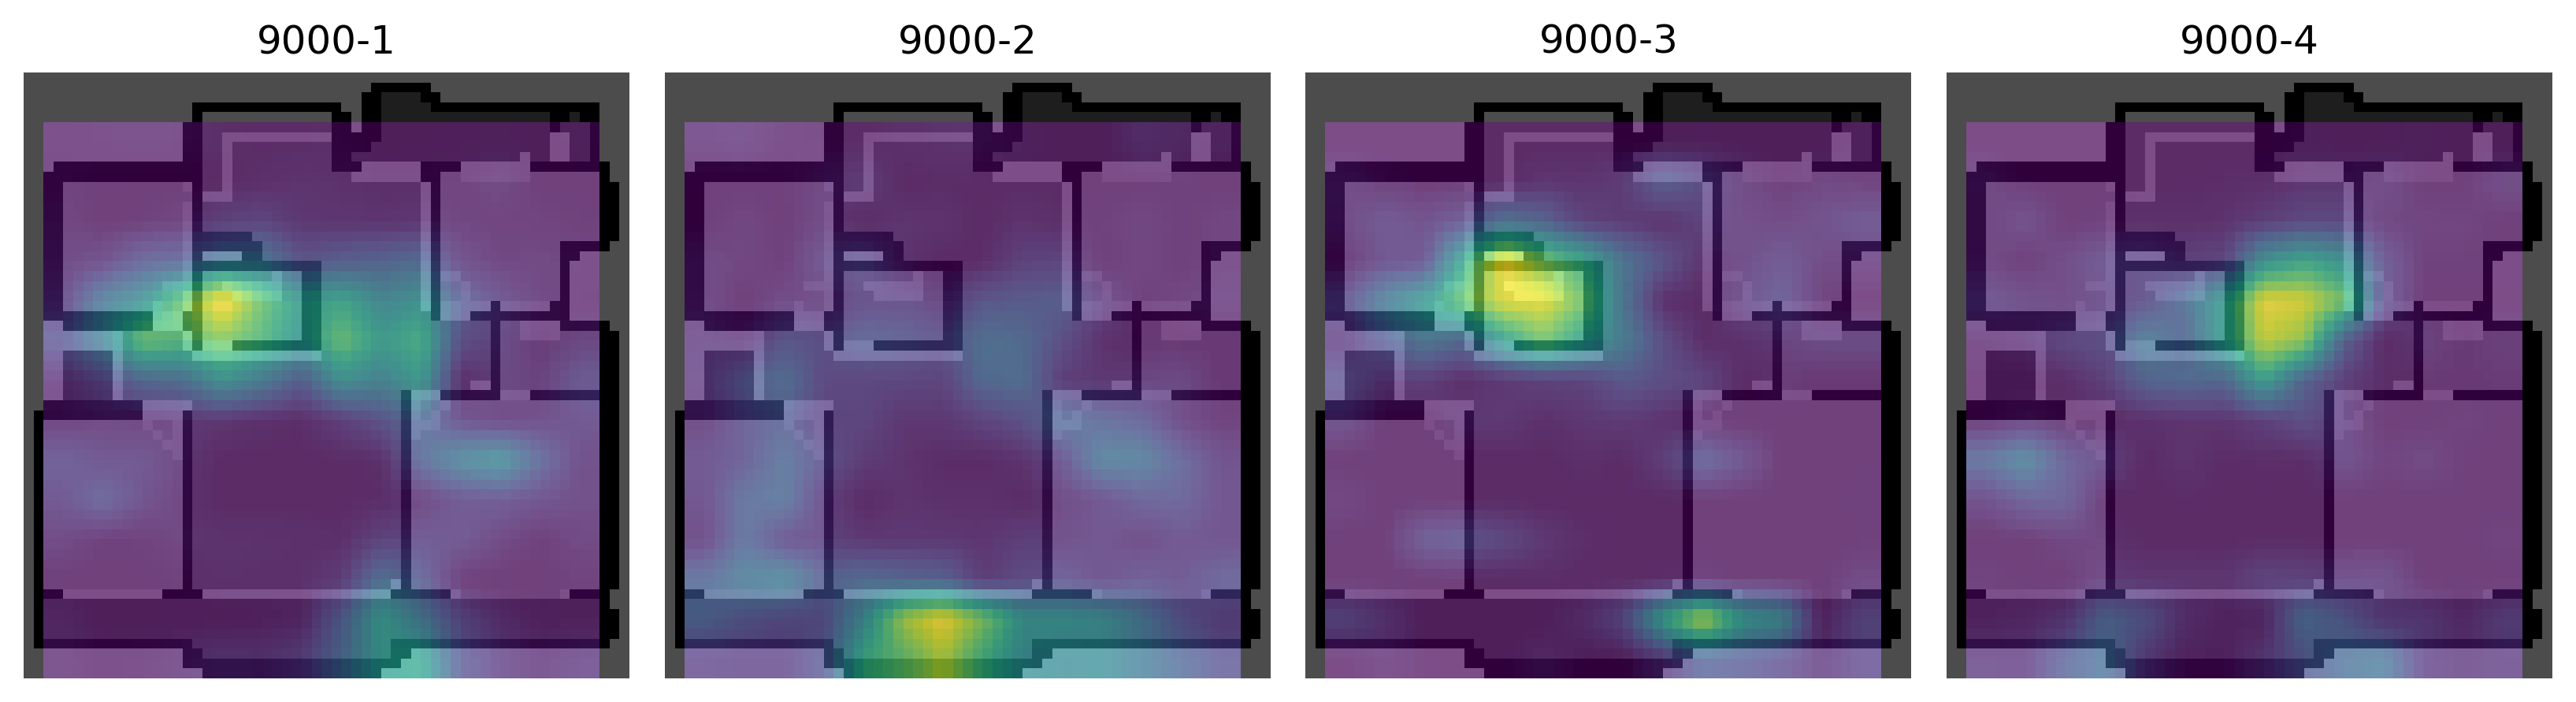

In [61]:
id_ = "2292_116"

fig1 = plot_bams(id_, [1, 2, 3])
fig2 = plot_bams(id_, range(4, 7 + 1))

# fig.savefig("bam.png", bbox_inches="tight", pad_inches=0)
# fig.savefig("bam.pdf", bbox_inches="tight", pad_inches=0)

# 2000년대: 발코니, 코어 후면 배치

In [62]:
df_sample[
    (df_sample.year >= 2000)
    & (df_sample.year < 2010)
    & (df_sample.cluster.isin([9]))
    & (df_sample.area_group == 2)
]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
21556,21556,21556,19006_111A,7,7,2005,1,84.99,3,2,9,2
24752,24752,24752,17566_118,7,7,2005,1,84.58,3,2,9,2
37312,37312,37312,22723_101,7,6,2005,4,74.50,3,2,9,2
25315,25315,25315,14039_111B,7,7,2006,1,84.87,3,2,9,2
37350,37350,37350,17466_96,7,7,2006,4,69.89,3,2,9,2
10091,10091,10091,22158_103E,7,7,2008,0,84.82,3,2,9,2


판상형
중형

경기
동화옥시죤5차,
84.58㎡,
2005년

17566_118
17566_118


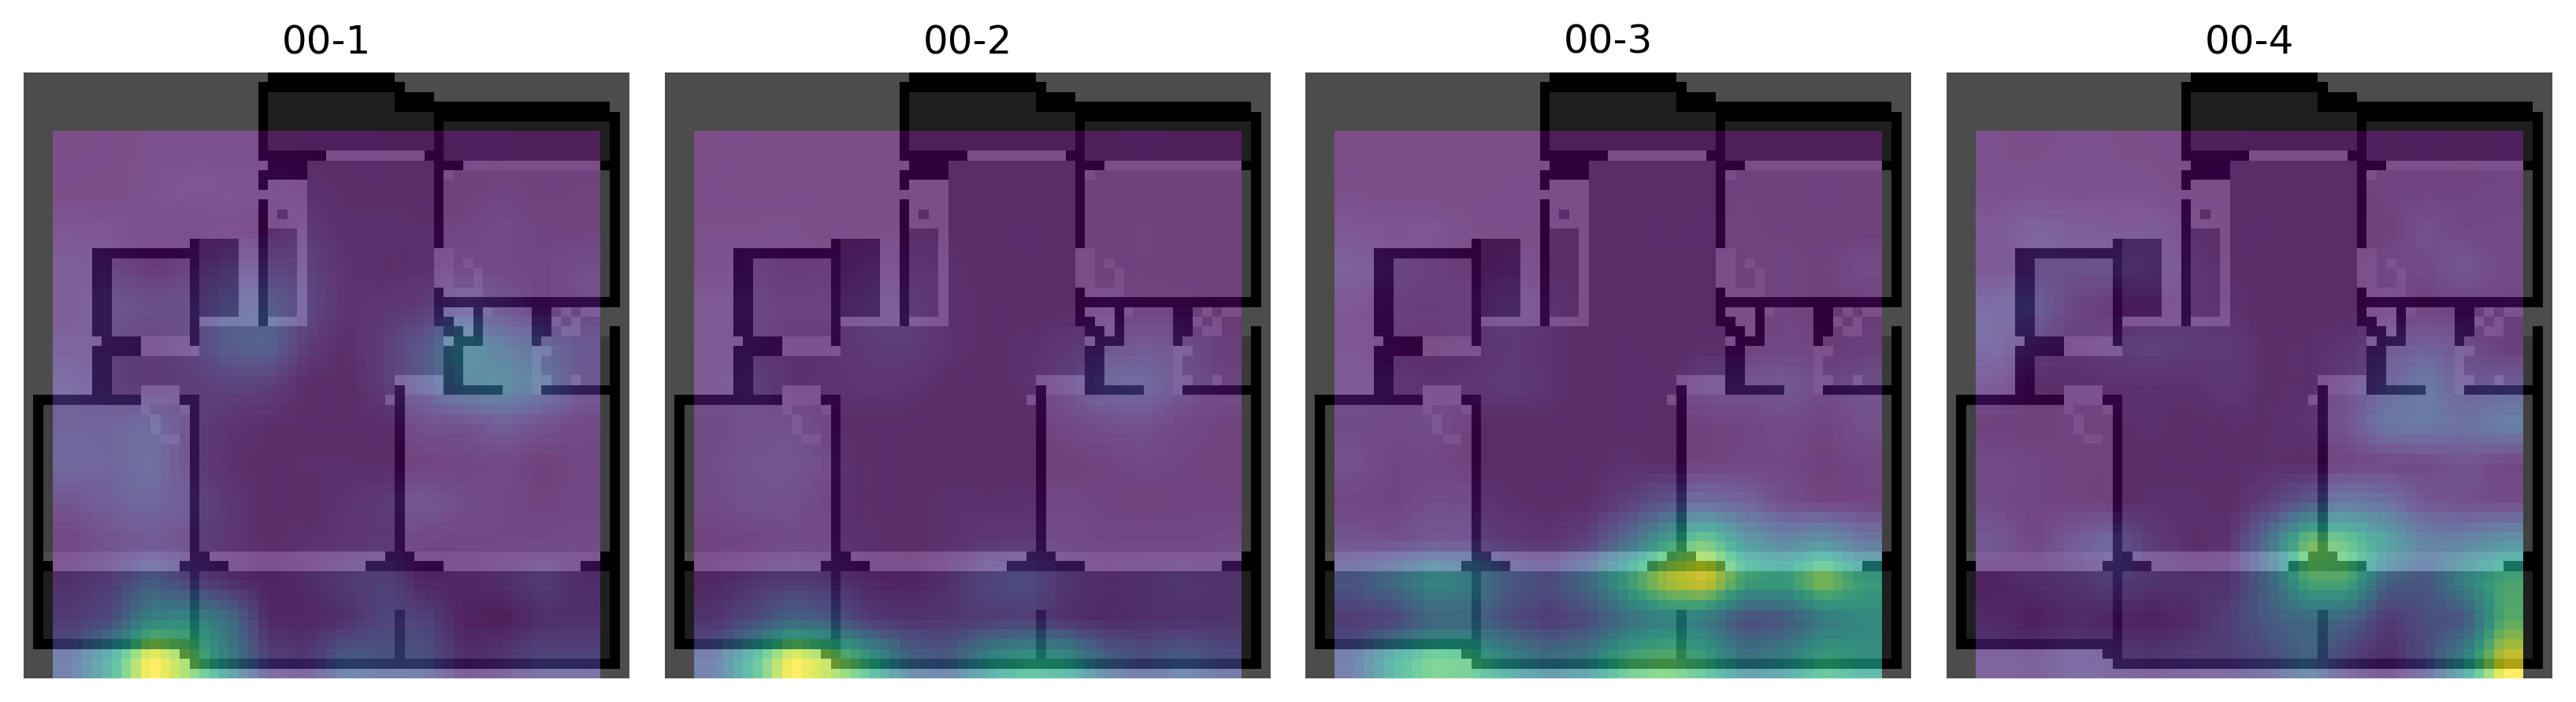

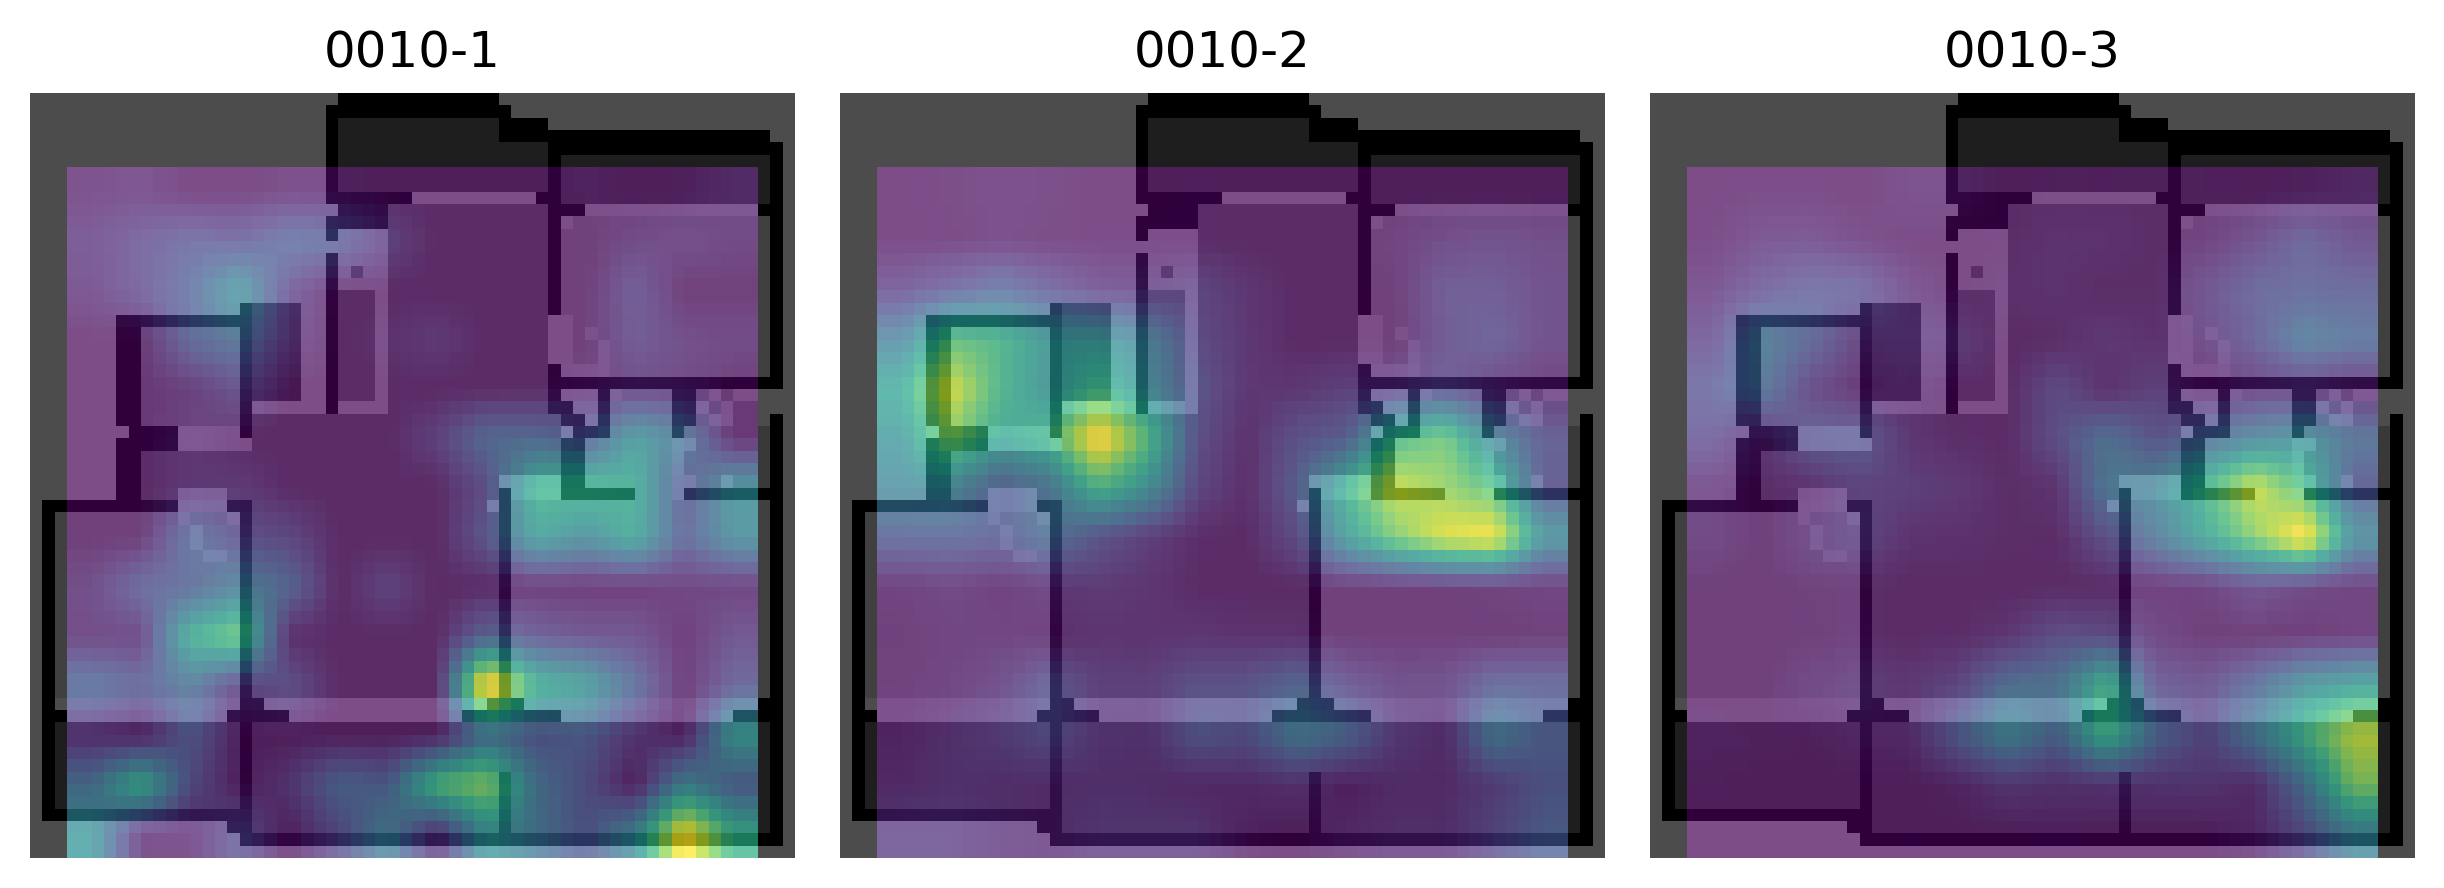

In [63]:
id_ = "17566_118"

fig1 = plot_bams(id_, range(8, 11 + 1))
fig2 = plot_bams(id_, range(12, 14 + 1))

# 2010년대: 탑상형, 원룸형

In [64]:
df_sample[(df_sample.cluster.isin([13])) & (df_sample.area_group == 2)]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
18704,18704,18704,100677_115A,7,8,2009,1,84.99,3,2,13,2
24213,24213,24213,102095_113A,7,7,2009,1,84.17,3,2,13,2
7766,7766,7766,101160_113E,8,8,2012,0,84.92,3,2,13,2
47728,47728,47728,103915_112C,8,8,2013,5,84.83,3,2,13,2
12555,12555,12555,104127_107B,8,8,2013,0,80.37,3,2,13,2
9175,9175,9175,107903_113G,8,8,2014,0,84.61,3,2,13,2
42716,42716,42716,108838_117B,9,9,2016,7,84.98,3,2,13,2


탑상형 중앙부
중형

서울 서초포레스타5,
84.4㎡,
2014년

107903_112B3
107903_112B3


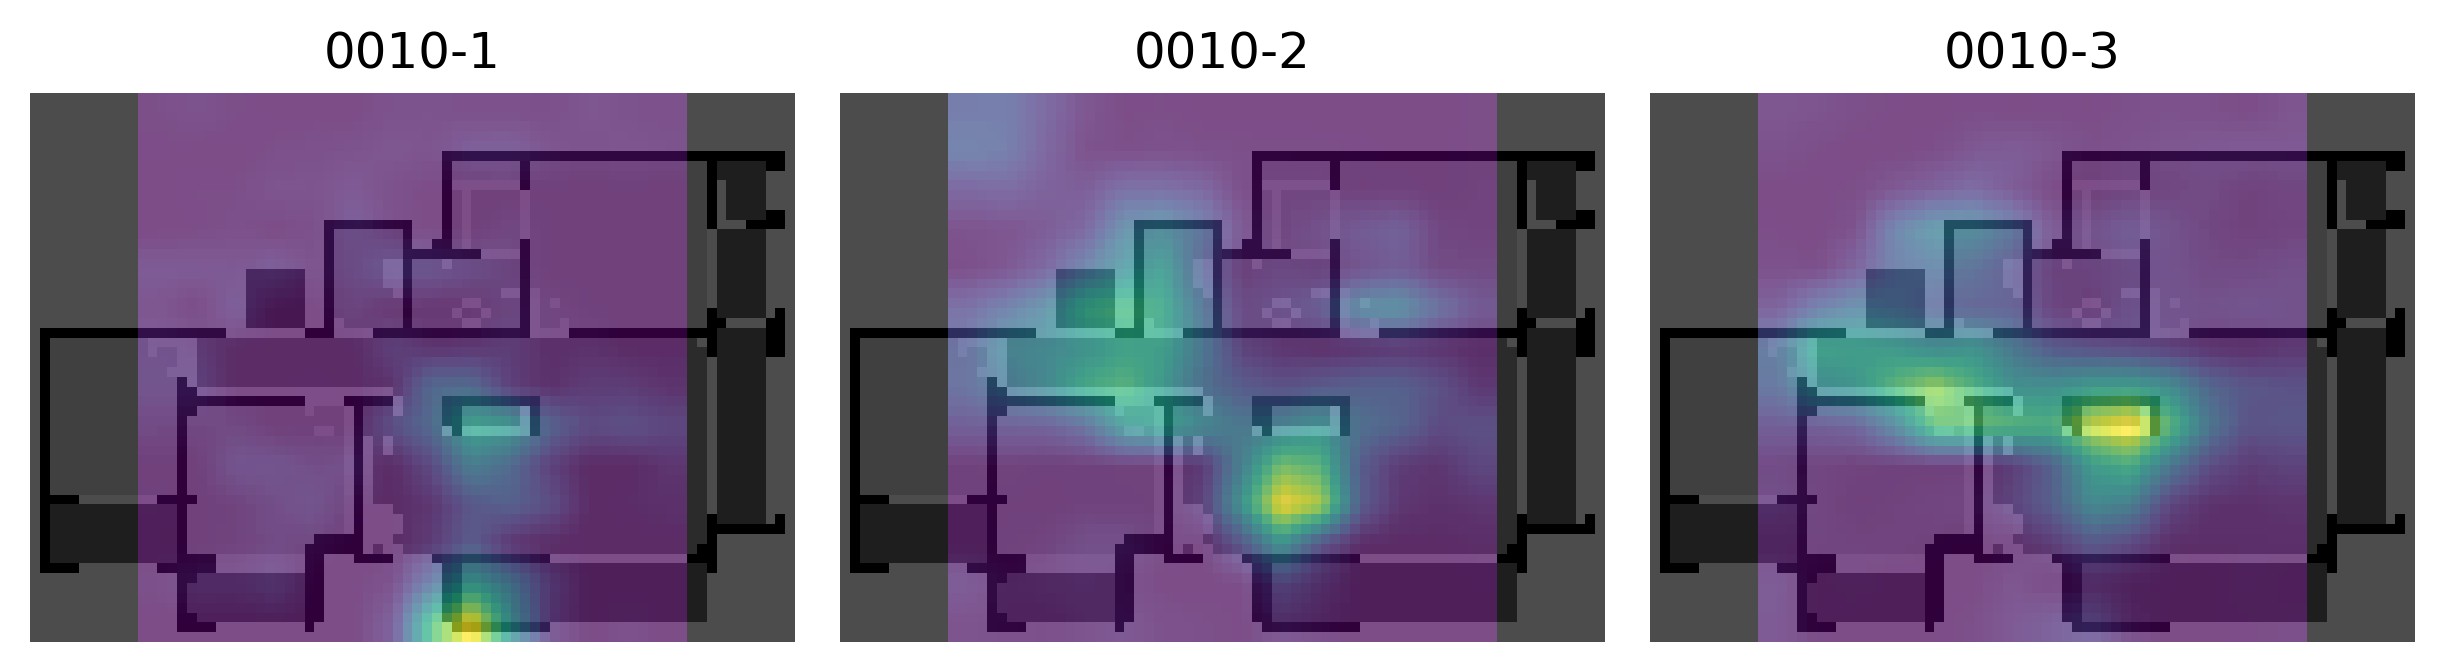

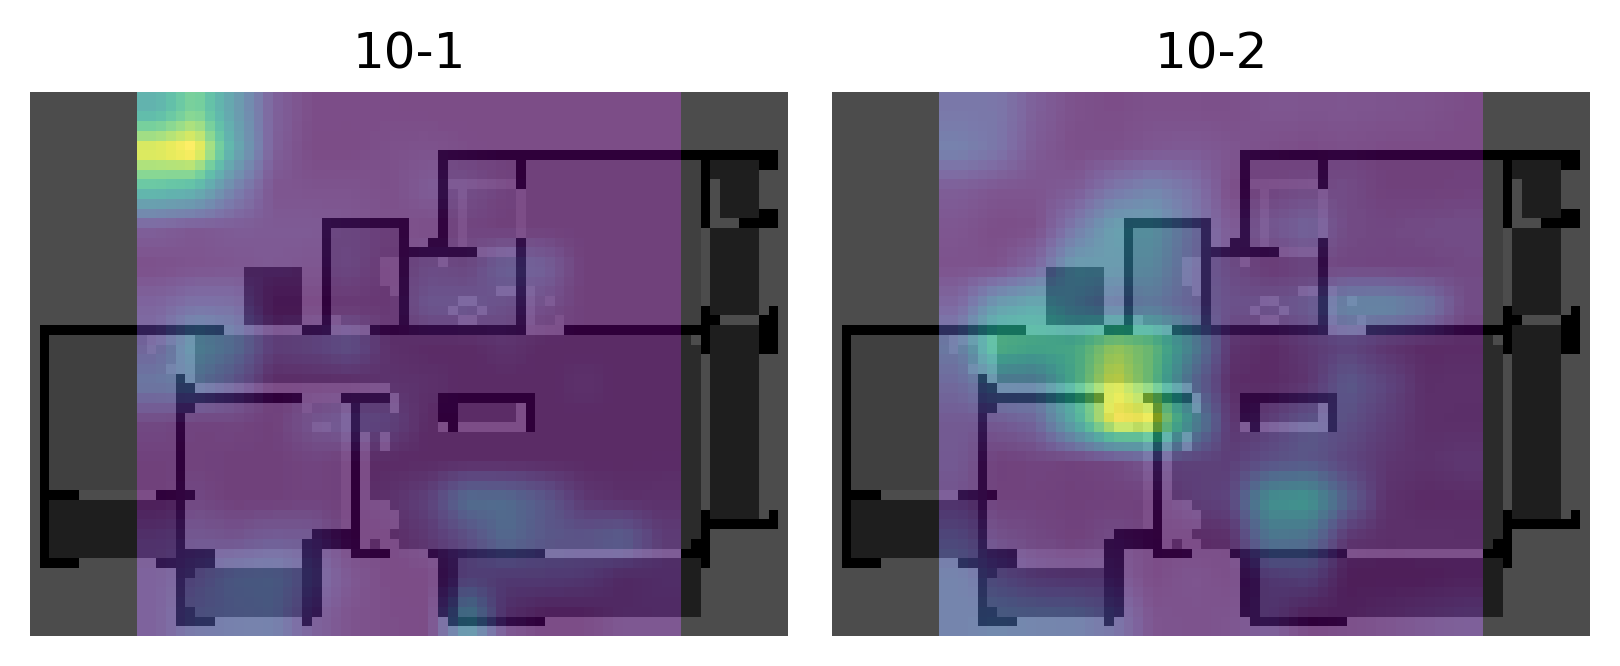

In [65]:
id_ = "107903_112B3"

fig1 = plot_bams(id_, range(12, 14 + 1))
fig2 = plot_bams(id_, range(15, 16 + 1))

In [66]:
df_sample[(df_sample.cluster.isin([15])) & (df_sample.area_group == 2)]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
3638,3638,3638,27528_90,7,9,2009,0,75.70,3,1,15,2
4373,4373,4373,27310_118,8,9,2011,0,84.96,3,2,15,2
33860,33860,33860,108744_96C,8,9,2013,5,80.35,3,2,15,2
4538,4538,4538,107066_112F,8,9,2014,0,84.97,3,2,15,2
41311,41311,41311,107076_106C,8,9,2014,4,79.59,4,2,15,2
32689,32689,32689,104870_113A,8,9,2014,5,84.94,3,2,15,2
19018,19018,19018,108488_114C,9,9,2015,1,84.99,3,2,15,2
42592,42592,42592,108406_105,9,9,2015,7,83.94,3,2,15,2
28102,28102,28102,107653_114F,9,9,2015,1,84.99,3,2,15,2
8112,8112,8112,108832_124C,9,9,2015,0,84.87,3,2,15,2


탑상형 단부 중형

천안 백석더샵,
84.25㎡,
2016년

108523_111C
108523_111C


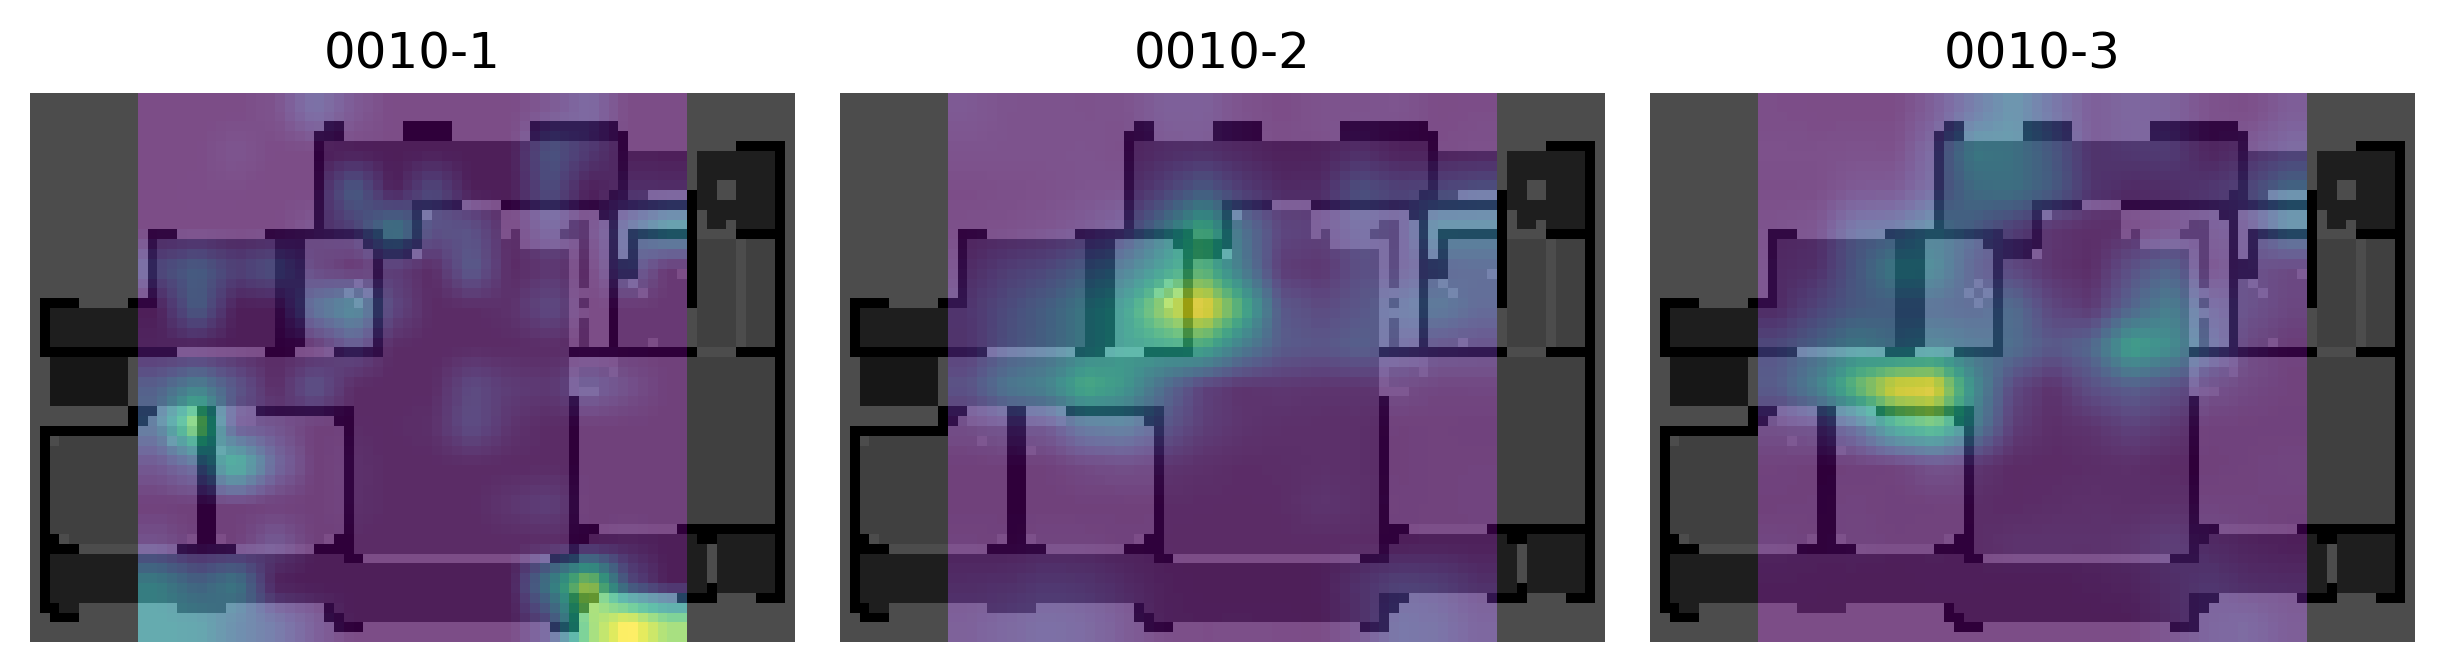

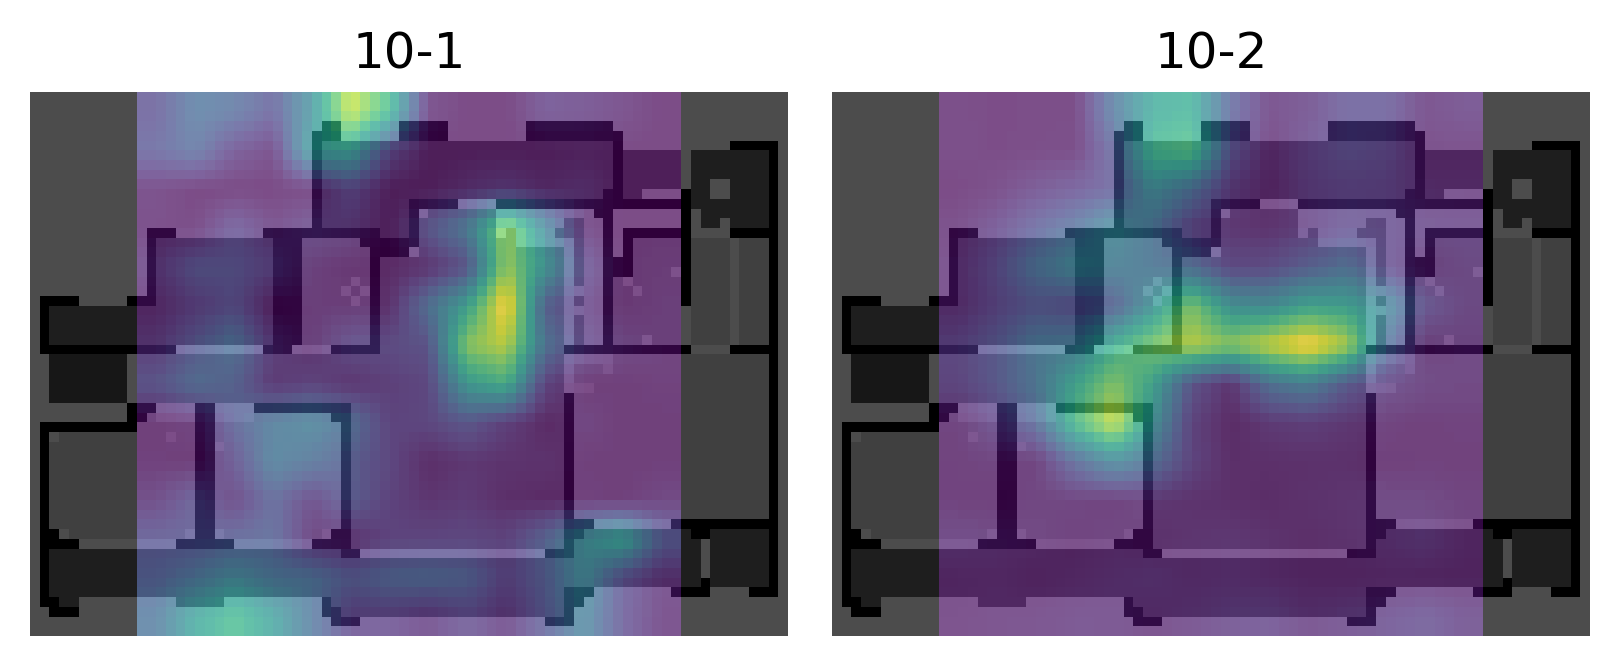

In [67]:
id_ = "108523_111C"

fig1 = plot_bams(id_, range(12, 14 + 1))
fig2 = plot_bams(id_, range(15, 16 + 1))

In [68]:
df_sample[(df_sample.cluster.isin([15]))& (df_sample.year >= 2010)& (df_sample.area_group == 2)]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
4373,4373,4373,27310_118,8,9,2011,0,84.96,3,2,15,2
33860,33860,33860,108744_96C,8,9,2013,5,80.35,3,2,15,2
4538,4538,4538,107066_112F,8,9,2014,0,84.97,3,2,15,2
41311,41311,41311,107076_106C,8,9,2014,4,79.59,4,2,15,2
32689,32689,32689,104870_113A,8,9,2014,5,84.94,3,2,15,2
19018,19018,19018,108488_114C,9,9,2015,1,84.99,3,2,15,2
42592,42592,42592,108406_105,9,9,2015,7,83.94,3,2,15,2
28102,28102,28102,107653_114F,9,9,2015,1,84.99,3,2,15,2
8112,8112,8112,108832_124C,9,9,2015,0,84.87,3,2,15,2
45620,45620,45620,108523_111C,9,9,2016,4,84.00,3,2,15,2


혼합형
(L자형 주동 계단실형 코어)

세종 가락4단지이지더원,
79.59㎡,
2014년

107076_106C
107076_106C


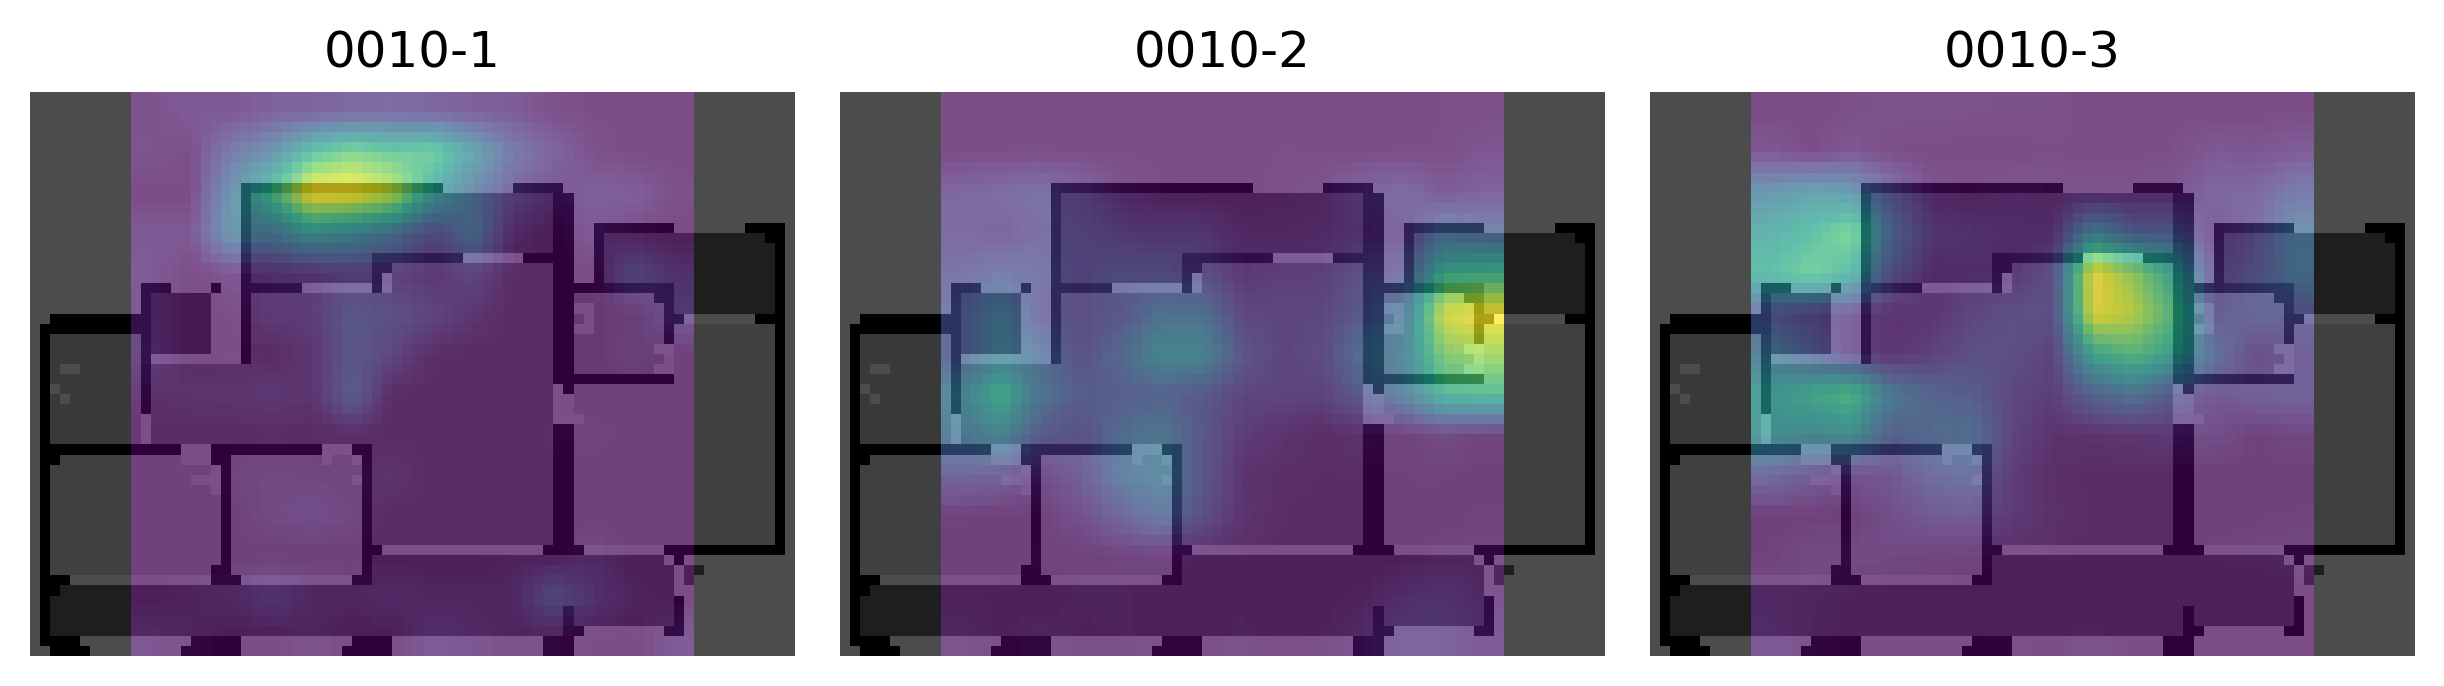

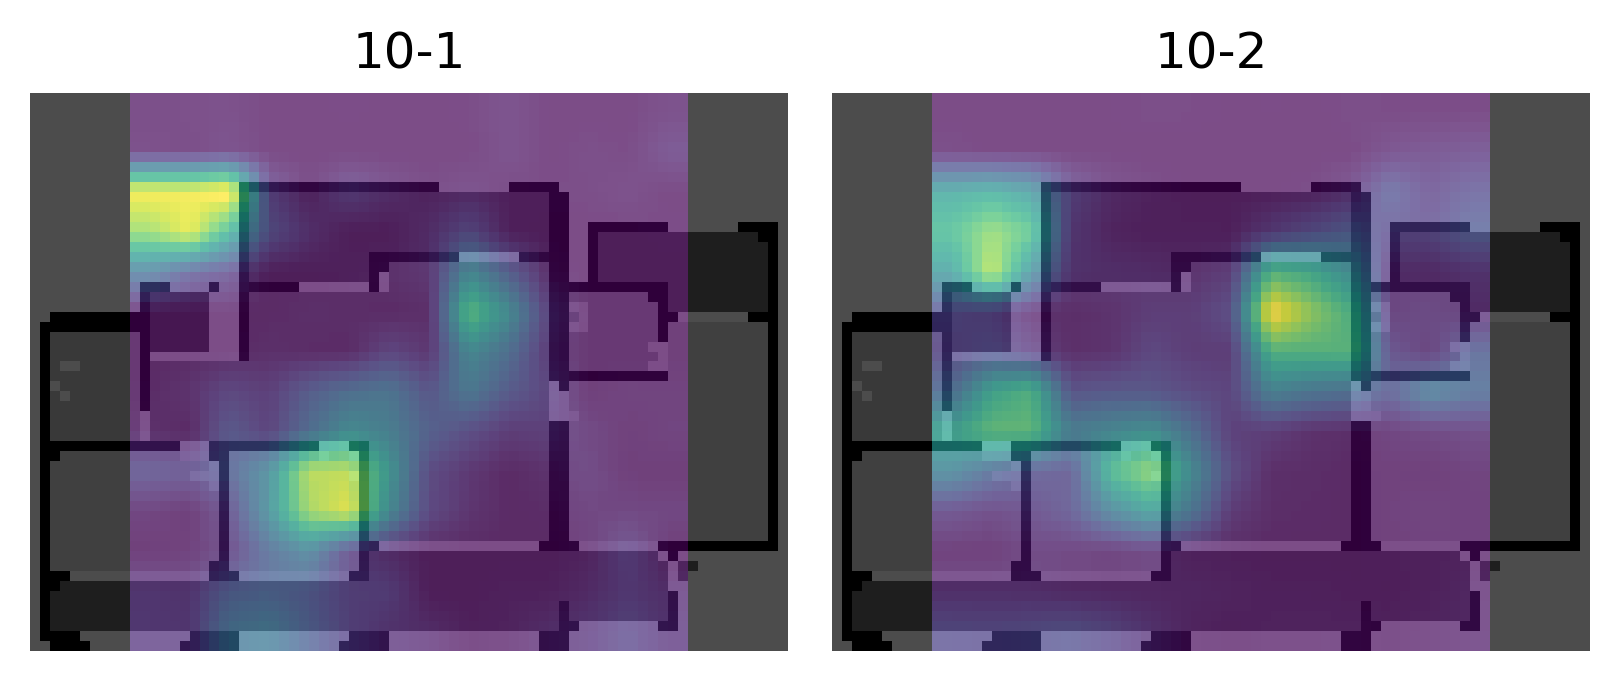

In [69]:
id_ = "107076_106C"

fig1 = plot_bams(id_, range(12, 14 + 1))
fig2 = plot_bams(id_, range(15, 16 + 1))

In [70]:
df[(df.cluster.isin([14]))].Area.mean()

28.262562630480172

In [71]:
df[(df.cluster.isin([14]))].Area.median()

23.475

In [72]:
df[(df.cluster.isin([14]))& (df.year >= 2010) & (df.Area >= 23) & (df.Area <= 29)]

,Unnamed: 0,Unnamed: 0.1,ID,true,prediction,year,sido_cluster_code,Area,Rooms,Baths,cluster,area_group
937,937,937,104259_36G,8,8,2012,0,23.62,1,1,14,0
1001,1001,1001,104666_38E,8,9,2012,0,24.79,1,1,14,0
1002,1002,1002,104666_39D-1,8,9,2012,0,25.56,1,1,14,0
1003,1003,1003,104666_39D,8,9,2012,0,25.61,1,1,14,0
1004,1004,1004,104666_42B-1,8,8,2012,0,27.59,1,1,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48994,48994,48994,109957_37B-4,9,8,2015,7,26.17,1,1,14,0
50129,50129,50129,112571_44,9,9,2015,8,28.02,1,1,14,0
50249,50249,50249,115454_36B,9,9,2017,8,24.86,3,2,14,0
50250,50250,50250,115454_37A,9,9,2017,8,25.67,3,2,14,0


원룸형 도시형생활주택

서울 역삼대명벨리온,
23.62㎡,
2012년

104259_36G


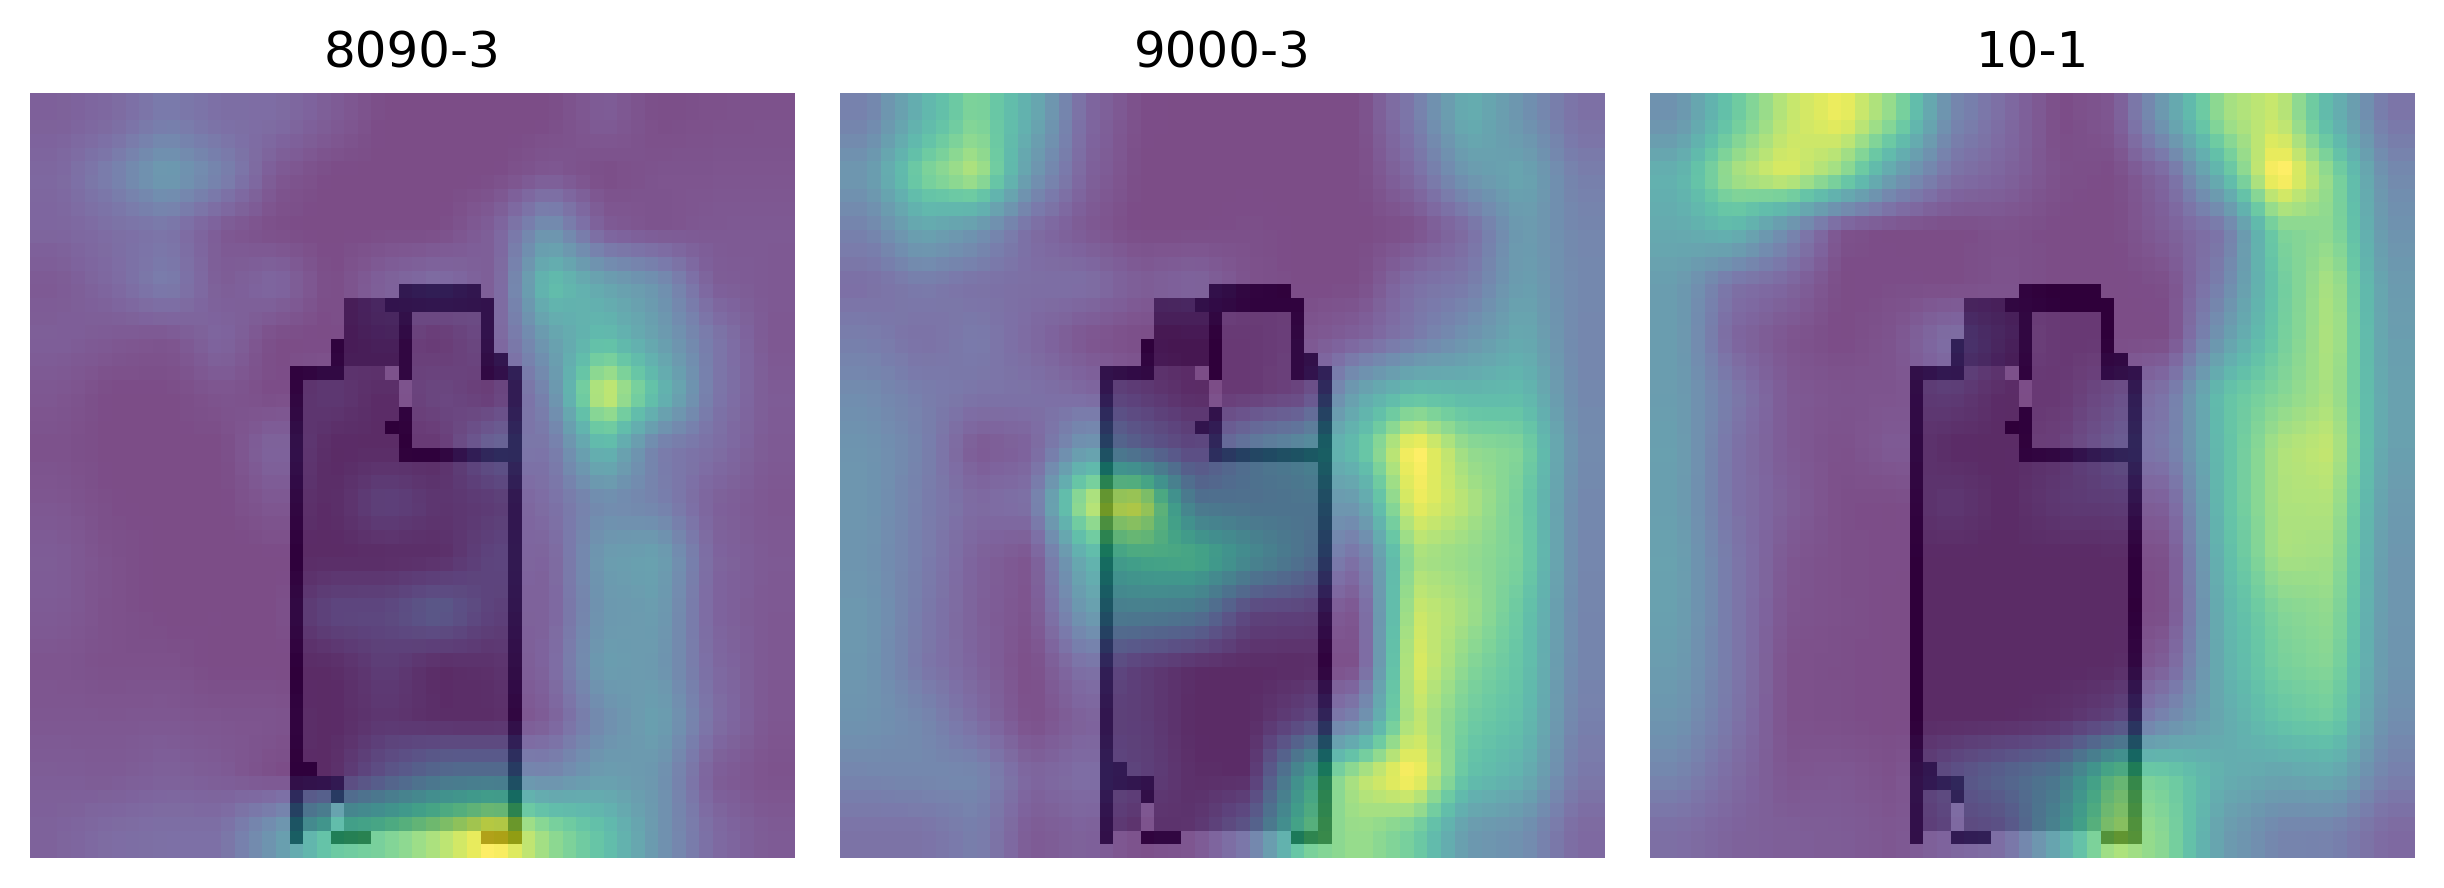

In [73]:
id_ = "104259_36G"

fig = plot_bams(id_, [3,6,15])